# **ML in medicion  - Task 3**  
## **Team Members**:  
- **Itamar Melnik** (ID: 207312307)  


In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy.stats import kruskal, chi2_contingency
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.impute import SimpleImputer
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from scipy.cluster.hierarchy import linkage, dendrogram
import warnings
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.metrics import (accuracy_score, precision_score, recall_score, precision_recall_curve, auc,
                           f1_score, roc_auc_score, roc_curve, confusion_matrix)
warnings.filterwarnings('ignore')

### **Loading MIMIC-III Clinical Data**

In [40]:
df = pd.read_csv("C:\\Users\\ItamarMelnik\\Desktop\\ML in medicine\\task3\\MIMIC_data_sample_mortality.csv")

In [41]:
df.head(10)

,icustay_id,hadm_id,subject_id,thirtyday_expire_flag,icu_los,age,gender,is_male,ethnicity,race_white,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,205941,156324,88883,1,1.9945,80.5274,M,1,WHITE,1,...,66.000000,20.0,28.0,24.419355,NaN,NaN,NaN,93.0,97.0,95.275862
1,252848,163315,46154,1,0.4003,91.4000,M,1,UNKNOWN/NOT SPECIFIED,0,...,51.888889,16.0,34.0,26.500000,37.388889,37.444444,37.416667,NaN,NaN,NaN
2,237901,180937,42682,0,8.7838,80.9409,F,0,WHITE,1,...,66.512821,16.0,23.0,19.571429,33.833333,36.888889,35.879630,87.0,100.0,98.100000
3,207491,143962,45111,1,3.1559,84.8807,M,1,WHITE,1,...,60.833333,20.0,31.0,24.520000,36.222222,36.666667,36.472222,90.0,100.0,97.600000
4,293063,118489,56648,1,0.5614,73.8195,F,0,WHITE,1,...,76.894737,20.0,46.0,32.117647,35.833333,36.944444,36.222222,86.0,100.0,96.250000
5,282497,140990,77067,0,15.3732,42.3418,F,0,WHITE,1,...,67.296296,17.0,30.0,24.593750,36.444444,39.722222,38.282828,90.0,98.0,93.608696
6,270282,173873,69630,1,1.9756,91.4000,F,0,UNKNOWN/NOT SPECIFIED,0,...,50.571429,15.0,24.0,17.711538,35.000000,36.111111,35.755556,55.0,100.0,94.500000
7,278456,106899,90008,1,6.0275,79.0599,F,0,WHITE,1,...,64.034483,10.0,25.0,18.741935,34.777778,36.333333,35.516667,90.0,100.0,96.062500
8,250393,191230,30139,0,36.0463,79.0709,F,0,WHITE,1,...,72.166667,20.0,29.0,25.733333,36.111111,37.277778,36.870370,92.0,99.0,94.869565
9,217790,178126,90903,0,5.9391,56.7076,M,1,WHITE,1,...,67.419355,20.0,31.0,24.156250,35.722222,36.944444,36.436508,93.0,98.0,95.096774


In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Data columns (total 72 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   icustay_id             4559 non-null   int64  
 1   hadm_id                4559 non-null   int64  
 2   subject_id             4559 non-null   int64  
 3   thirtyday_expire_flag  4559 non-null   int64  
 4   icu_los                4559 non-null   float64
 5   age                    4559 non-null   float64
 6   gender                 4559 non-null   object 
 7   is_male                4559 non-null   int64  
 8   ethnicity              4559 non-null   object 
 9   race_white             4559 non-null   int64  
 10  race_black             4559 non-null   int64  
 11  race_hispanic          4559 non-null   int64  
 12  race_other             4559 non-null   int64  
 13  metastatic_cancer      4559 non-null   int64  
 14  diabetes               4559 non-null   int64  
 15  firs

### **Data Cleaning - Removing Non-SOFA and Redundant Variables**

In [43]:
columns_to_remove = [
    # IDs and potential data leakage
    'icustay_id', 'hadm_id', 'subject_id', 'icu_los',
    
    # Redundant demographics
    'gender',  # We have is_male
    'ethnicity', 'race_black', 'race_hispanic', 'race_other',
    
    
    # Non-SOFA vitals 
    'heartrate_min', 'heartrate_max', 'heartrate_mean',
    'sysbp_min', 'sysbp_max', 'sysbp_mean',
    'diasbp_min', 'diasbp_max', 'diasbp_mean',
    'resprate_min', 'resprate_max', 'resprate_mean',
    'tempc_min', 'tempc_max', 'tempc_mean',
    
    # Non-SOFA lab values
    'bicarbonate_min', 'bicarbonate_max',
    'chloride_min', 'chloride_max',
    'glucose_min', 'glucose_max', 'glucose_min1', 'glucose_max1', 'glucose_mean',
    'hematocrit_min', 'hematocrit_max',
    'hemoglobin_min', 'hemoglobin_max',
    'lactate_min', 'lactate_max', 'lactate_mean',
    'potassium_min', 'potassium_max',
    'inr_min', 'inr_max',
    'sodium_min', 'sodium_max',
    'bun_min', 'bun_max', 'bun_mean',
    'wbc_min', 'wbc_max', 'wbc_mean',

     # Remove urineoutput due to lack of variability
    'urineoutput'
]

# Remove non-SOFA related columns
df = df.drop(columns=columns_to_remove)


In [44]:
df.describe()

,thirtyday_expire_flag,age,is_male,race_white,metastatic_cancer,diabetes,vent,sofa,creatinine_min,creatinine_max,platelet_min,platelet_max,meanbp_min,meanbp_max,meanbp_mean,spo2_min,spo2_max,spo2_mean
count,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4559.000000,4557.000000,4557.000000,4553.000000,4553.000000,4559.000000,4559.000000,4559.000000,4558.000000,4558.000000,4558.000000
mean,0.194999,65.131600,0.566133,0.718579,0.060759,0.280325,0.555385,5.747313,1.356814,1.728242,195.935208,245.636284,54.740513,106.110331,76.168044,91.082273,99.570645,96.910880
std,0.396243,17.671337,0.495662,0.449742,0.238914,0.449207,0.496978,3.345240,1.287532,1.726172,113.680307,132.108412,14.492285,29.053489,10.503878,7.812963,0.969895,2.480538
min,0.000000,16.783400,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.100000,0.100000,5.000000,16.000000,1.000000,56.000000,45.600000,1.000000,89.000000,55.869565
25%,0.000000,53.764350,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.700000,0.900000,122.000000,159.000000,49.000000,90.000000,69.041667,90.000000,100.000000,95.800000
50%,0.000000,66.588700,1.000000,1.000000,0.000000,0.000000,1.000000,5.000000,1.000000,1.200000,178.000000,224.000000,56.000000,101.000000,75.000000,93.000000,100.000000,97.258662
75%,0.000000,79.525350,1.000000,1.000000,0.000000,1.000000,1.000000,7.000000,1.400000,1.900000,246.000000,303.000000,63.000000,114.000000,82.412879,95.000000,100.000000,98.600000
max,1.000000,91.400000,1.000000,1.000000,1.000000,1.000000,1.000000,21.000000,22.100000,27.800000,1297.000000,1775.000000,113.000000,298.000000,133.156250,100.000000,100.000000,100.000000


### **Missing Values Assessment**

In [45]:
missing_stats = pd.DataFrame({'Missing Count': df.isnull().sum(),})
missing_stats = missing_stats[missing_stats['Missing Count'] > 0].sort_values('Missing Count', ascending=False)
missing_stats

,Missing Count
platelet_min,6
platelet_max,6
creatinine_min,2
creatinine_max,2
spo2_min,1
spo2_max,1
spo2_mean,1


### **Outliers Analysis - Box Plots for Continuous Variables**

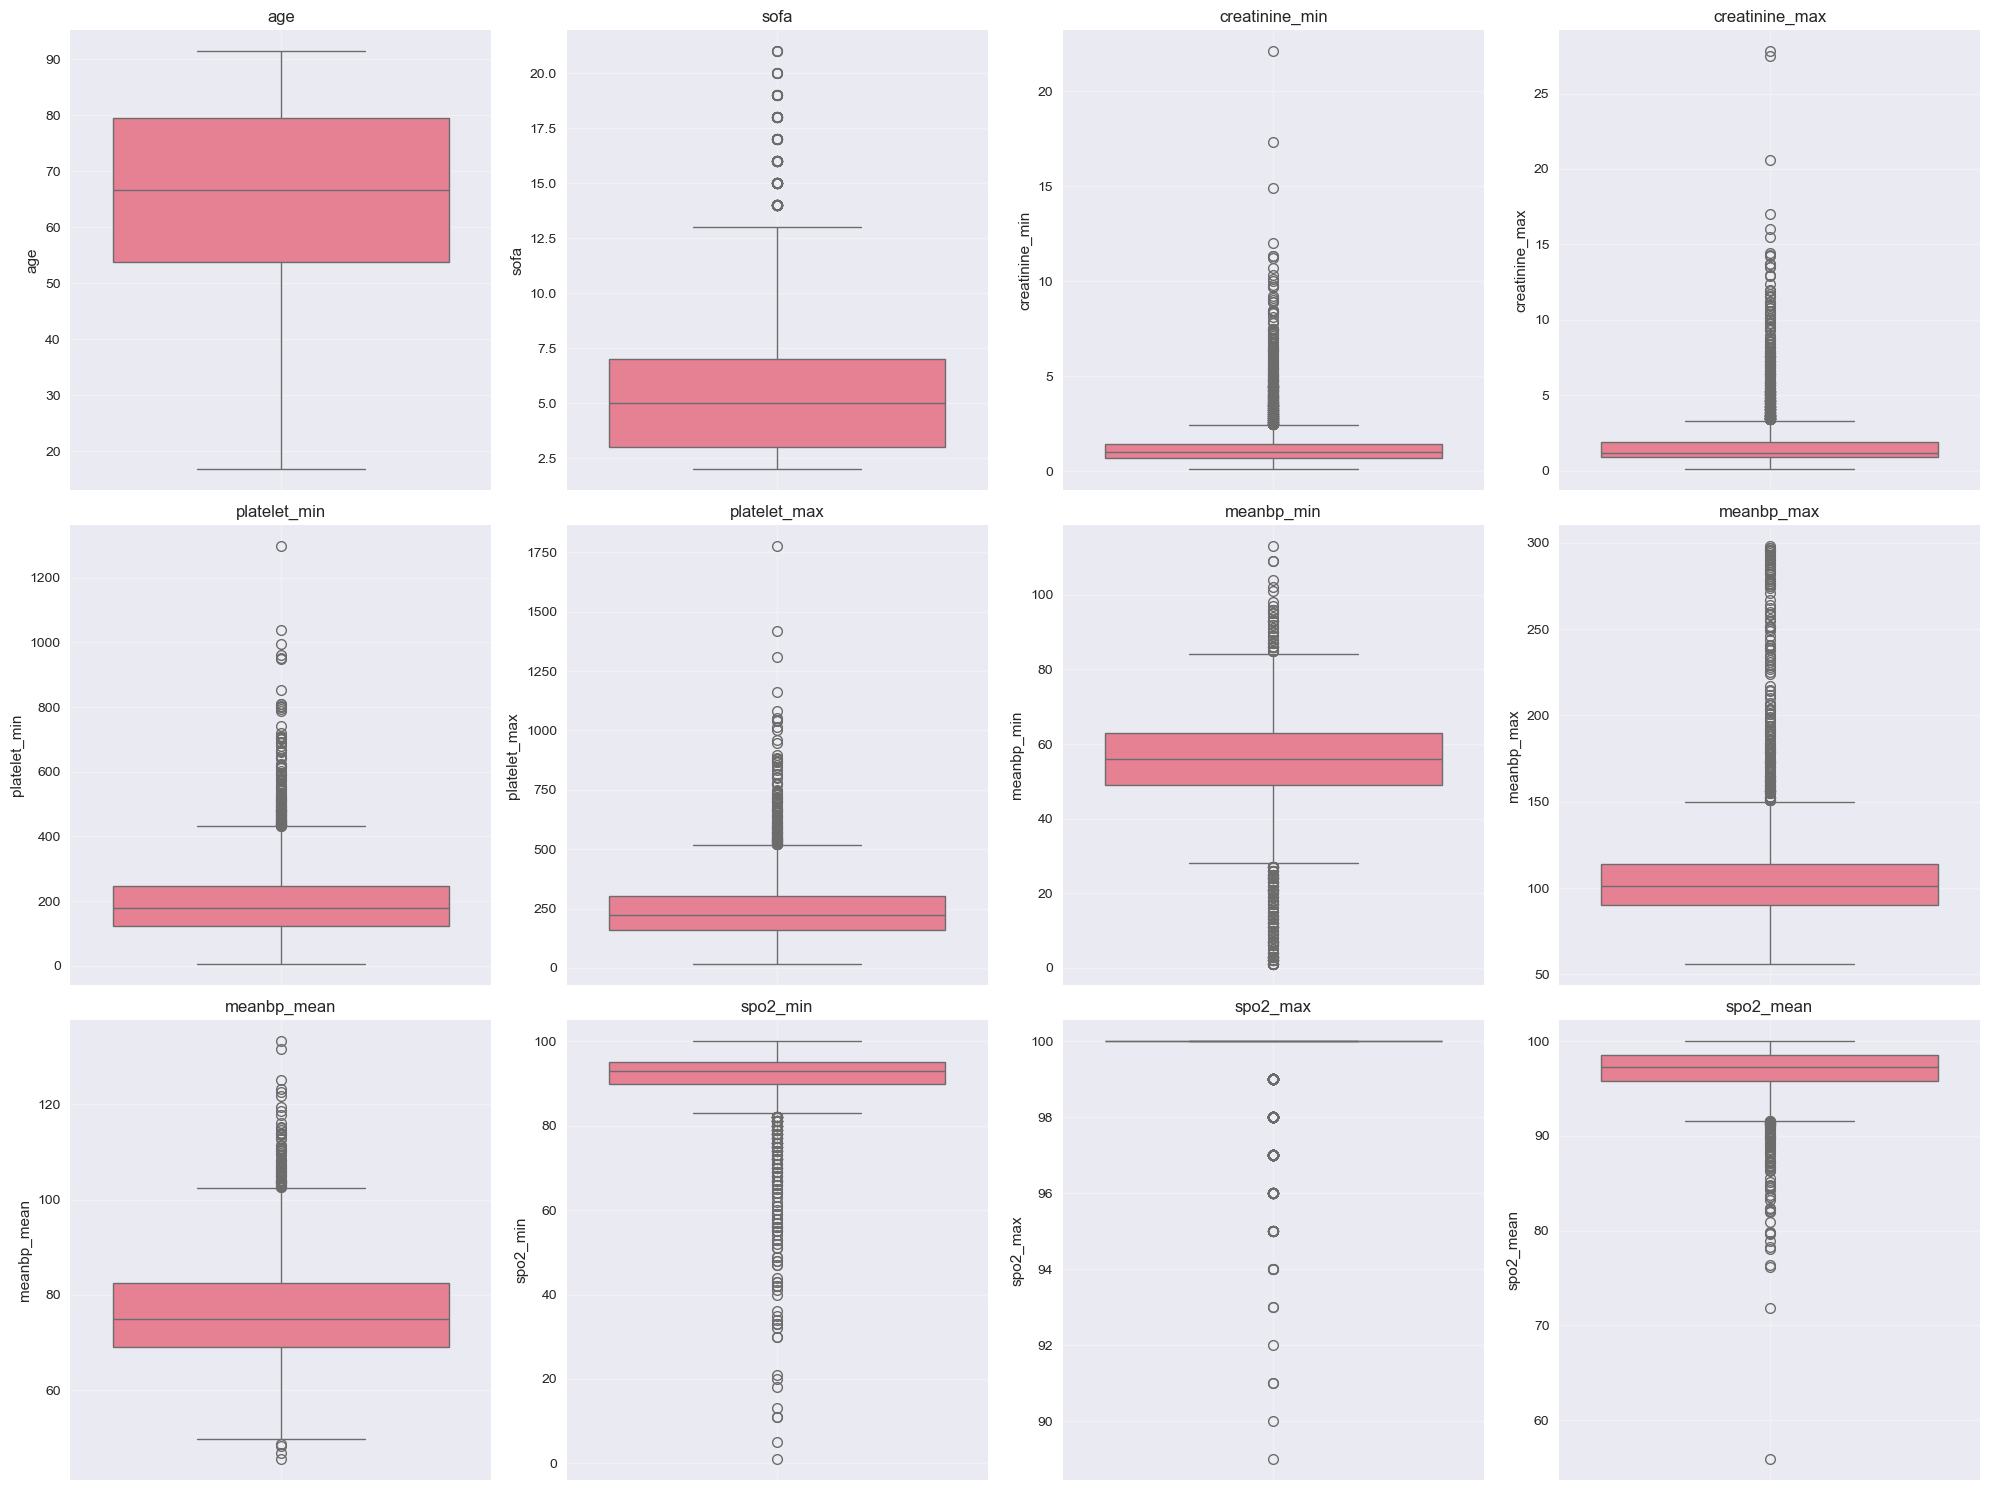

In [46]:
# Define specific continuous numeric columns for outlier analysis
numeric_cols = [
    'age', 'sofa', 'creatinine_min', 'creatinine_max', 
    'platelet_min', 'platelet_max', 'meanbp_min',
    'meanbp_max', 'meanbp_mean', 'spo2_min',
    'spo2_max', 'spo2_mean'
]

# Create box plots
n_cols = len(numeric_cols)
cols_per_row = 4
n_rows = (n_cols + cols_per_row - 1) // cols_per_row

fig, axes = plt.subplots(n_rows, cols_per_row, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes] if n_cols == 1 else axes

for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, y=col, ax=axes[i])
    axes[i].set_title(f'{col}')
    axes[i].grid(True, alpha=0.3)

# Hide empty subplots
for i in range(n_cols, len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()

### **Missing Values Imputation **

 All columns with missing values contain numerous outliers, therefore median imputation was chosen for robustness

In [47]:
# Apply median imputation using SimpleImputer
imputer = SimpleImputer(strategy='median')
df[df.select_dtypes(include='number').columns] = imputer.fit_transform(df.select_dtypes(include='number'))

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   thirtyday_expire_flag  4559 non-null   float64
 1   age                    4559 non-null   float64
 2   is_male                4559 non-null   float64
 3   race_white             4559 non-null   float64
 4   metastatic_cancer      4559 non-null   float64
 5   diabetes               4559 non-null   float64
 6   first_service          4559 non-null   object 
 7   vent                   4559 non-null   float64
 8   sofa                   4559 non-null   float64
 9   creatinine_min         4559 non-null   float64
 10  creatinine_max         4559 non-null   float64
 11  platelet_min           4559 non-null   float64
 12  platelet_max           4559 non-null   float64
 13  meanbp_min             4559 non-null   float64
 14  meanbp_max             4559 non-null   float64
 15  mean

### **Feature Engineering - Service Type Categorization**

In [49]:
df['first_service'].value_counts()

first_service
MED      2557
CMED      563
SURG      453
TRAUM     302
NSURG     298
NMED      136
ORTHO      90
OMED       80
GU         35
GYN        16
ENT        12
PSURG       9
OBS         8
Name: count, dtype: int64

In [50]:
# Map first_service to a binary indicator: 1 = MEDICAL, 0 = NON-MEDICAL
medical_services = ['MED', 'CMED', 'NMED', 'OMED']
df['is_medical'] = df['first_service'].isin(medical_services).astype(int)

# Drop the original service column
df = df.drop(columns=['first_service'])



### **Feature Engineering - Vital Signs Variability Metrics**

In [51]:
# Transform lab test columns to range and coefficient of variation

# Calculate ranges
df['creatinine_range'] = df['creatinine_max'] - df['creatinine_min']
df['platelet_range'] = df['platelet_max'] - df['platelet_min']
df['meanbp_range'] = df['meanbp_max'] - df['meanbp_min']
df['spo2_range'] = df['spo2_max'] - df['spo2_min']

# Calculate CV for meanbp & spo2
df['meanbp_cv'] = df['meanbp_range'] / df['meanbp_mean']
df['spo2_cv'] = df['spo2_range'] / df['spo2_mean']

# Drop original columns
df.drop(columns=['creatinine_min', 'creatinine_max', 'platelet_min', 'platelet_max','spo2_mean', 
                'meanbp_min', 'meanbp_max', 'meanbp_mean', 'spo2_min', 'spo2_max'], 
        inplace=True)

### **Correlation Analysis - Identifying Mortality Predictors and Multicollinearity**

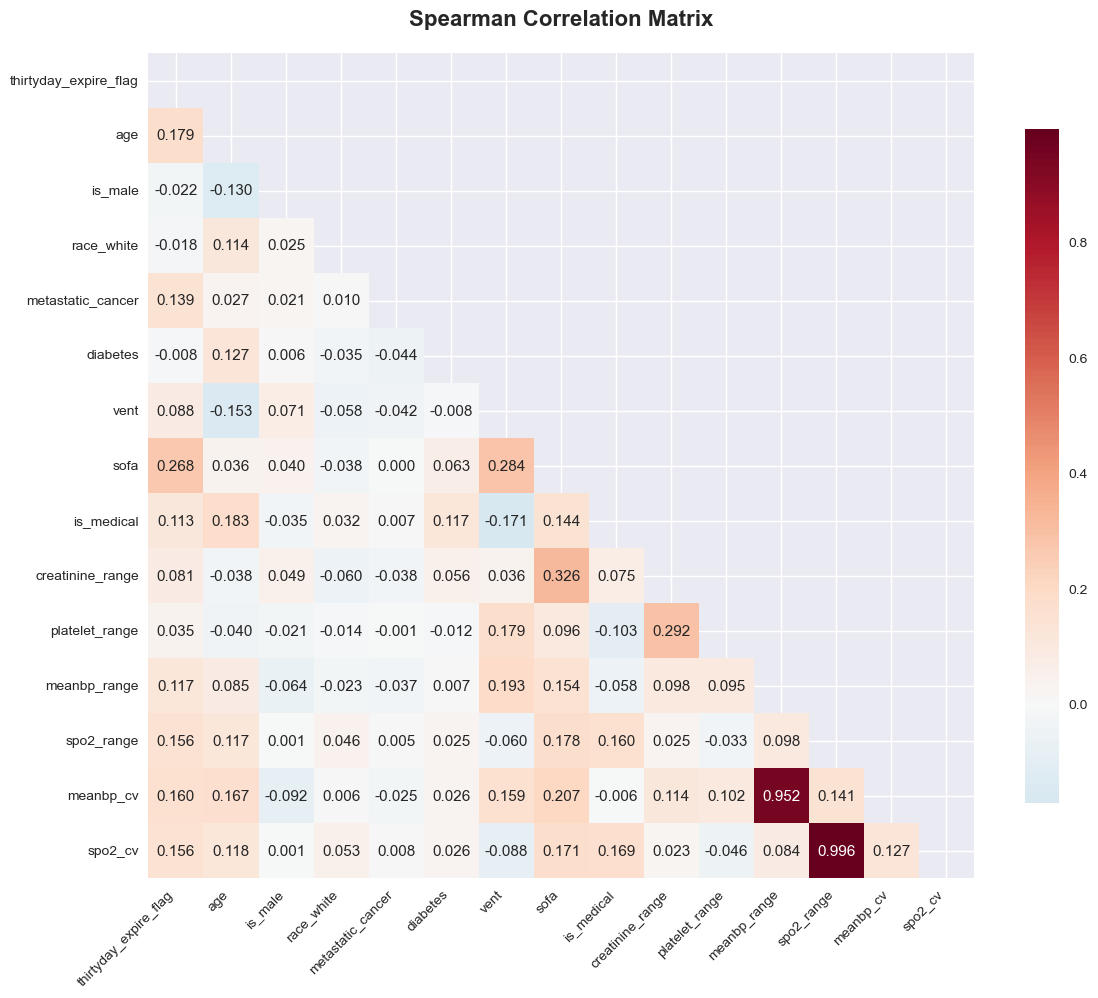

correlations with mortality:
sofa                 0.268
age                  0.179
meanbp_cv            0.160
spo2_range           0.156
spo2_cv              0.156
metastatic_cancer    0.139
meanbp_range         0.117
is_medical           0.113
vent                 0.088
creatinine_range     0.081
platelet_range       0.035
is_male             -0.022
race_white          -0.018
diabetes            -0.008
Name: thirtyday_expire_flag, dtype: float64


In [52]:
plt.figure(figsize=(12, 10))

# All numeric variables for correlation analysis
corr_vars = df.select_dtypes(include=[np.number]).columns.tolist()


correlation_matrix = df[corr_vars].corr(method='spearman')
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))

sns.heatmap(correlation_matrix, annot=True, cmap='RdBu_r', center=0, square=True,
            fmt='.3f', cbar_kws={"shrink": .8}, annot_kws={'size': 11}, mask=mask)

plt.title('Spearman Correlation Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Print correlations with mortality
mortality_corr = correlation_matrix['thirtyday_expire_flag'].drop('thirtyday_expire_flag').sort_values(key=abs, ascending=False)
print("correlations with mortality:")
print(mortality_corr.round(3))

### **Removing Low Correlation and Multicollinear Variables**

- **Low correlation variables**: `diabetes`, `race_white` 
- **Multicollinear variables**: `meanbp_range`, `spo2_range`

In [53]:
df=df.drop(columns=['diabetes','race_white','meanbp_range','spo2_range'])

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4559 entries, 0 to 4558
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   thirtyday_expire_flag  4559 non-null   float64
 1   age                    4559 non-null   float64
 2   is_male                4559 non-null   float64
 3   metastatic_cancer      4559 non-null   float64
 4   vent                   4559 non-null   float64
 5   sofa                   4559 non-null   float64
 6   is_medical             4559 non-null   int32  
 7   creatinine_range       4559 non-null   float64
 8   platelet_range         4559 non-null   float64
 9   meanbp_cv              4559 non-null   float64
 10  spo2_cv                4559 non-null   float64
dtypes: float64(10), int32(1)
memory usage: 374.1 KB


### **Categorical Variables Distribution**

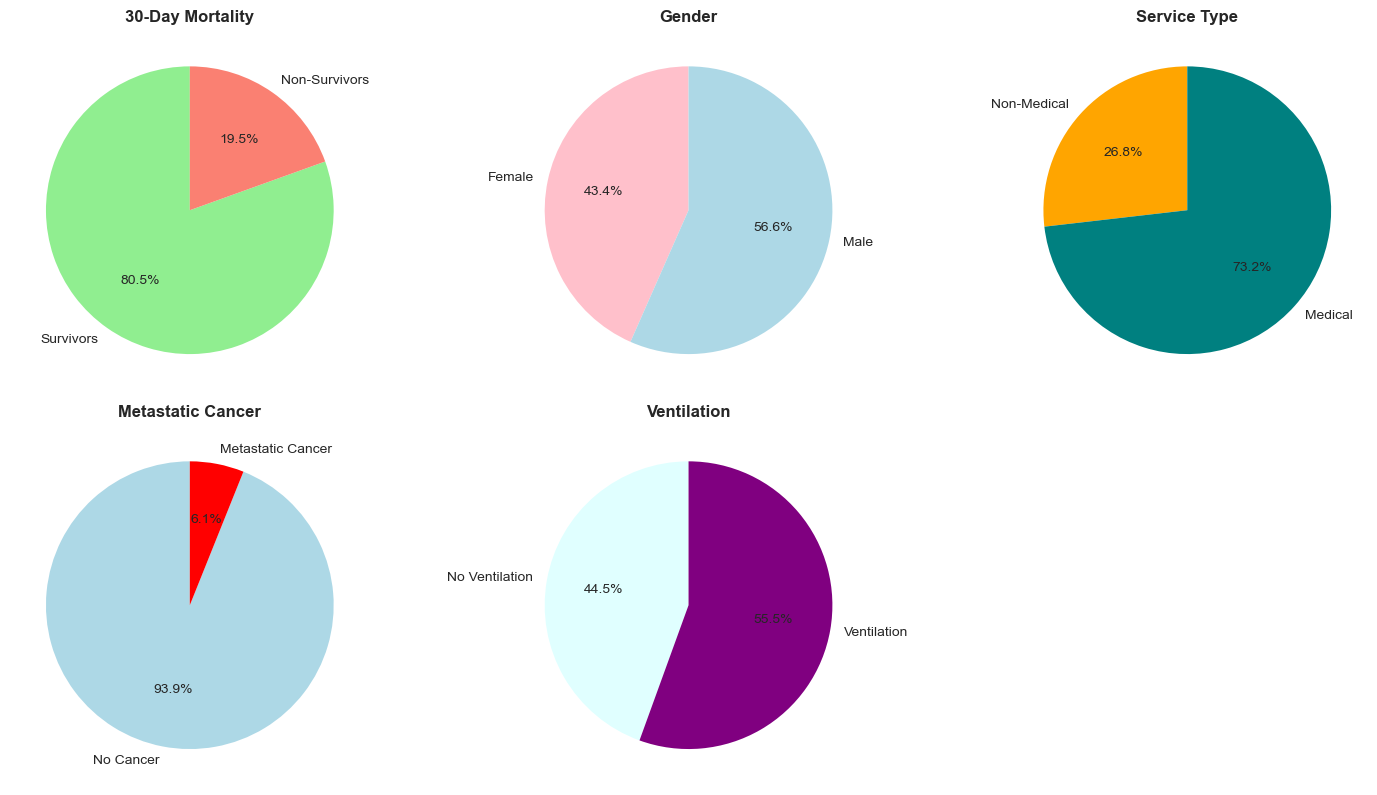

In [55]:
# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Define variables and their labels
pie_vars = {
    'thirtyday_expire_flag': {
        'labels': ['Survivors', 'Non-Survivors'],
        'colors': ['lightgreen', 'salmon'],
        'title': '30-Day Mortality'
    },
    'is_male': {
        'labels': ['Female', 'Male'],
        'colors': ['pink', 'lightblue'],
        'title': 'Gender'
    },
    'is_medical': {
        'labels': ['Non-Medical', 'Medical'],
        'colors': ['orange', 'teal'],
        'title': 'Service Type'
    },
    'metastatic_cancer': {
        'labels': ['No Cancer', 'Metastatic Cancer'],
        'colors': ['lightblue', 'red'],
        'title': 'Metastatic Cancer'
    },
    'vent': {
        'labels': ['No Ventilation', 'Ventilation'],
        'colors': ['lightcyan', 'purple'],
        'title': 'Ventilation'
    }
}

# Create pie charts
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, (var, config) in enumerate(pie_vars.items()):
    if var in df.columns:
        counts = df[var].value_counts().sort_index()

        if len(counts) > 0:
            labels = config['labels'] if config['labels'] else counts.index
            colors = config['colors'] if config['colors'] else None

            axes[i].pie(counts.values, labels=labels, autopct='%1.1f%%',
                        startangle=90, colors=colors)
            axes[i].set_title(config['title'], fontsize=12, fontweight='bold')
        else:
            axes[i].text(0.5, 0.5, 'No Data', ha='center', va='center')
            axes[i].set_title(config['title'], fontsize=12, fontweight='bold')
    else:
        axes[i].set_visible(False)

# Hide empty subplots
for i in range(len(pie_vars), len(axes)):
    axes[i].set_visible(False)

plt.tight_layout()
plt.show()


### **Descriptive Statistics - Key Variables vs Mortality Outcomes**

Exploring relationships between SOFA score, age, vital signs variability, and service types with 30-day mortality

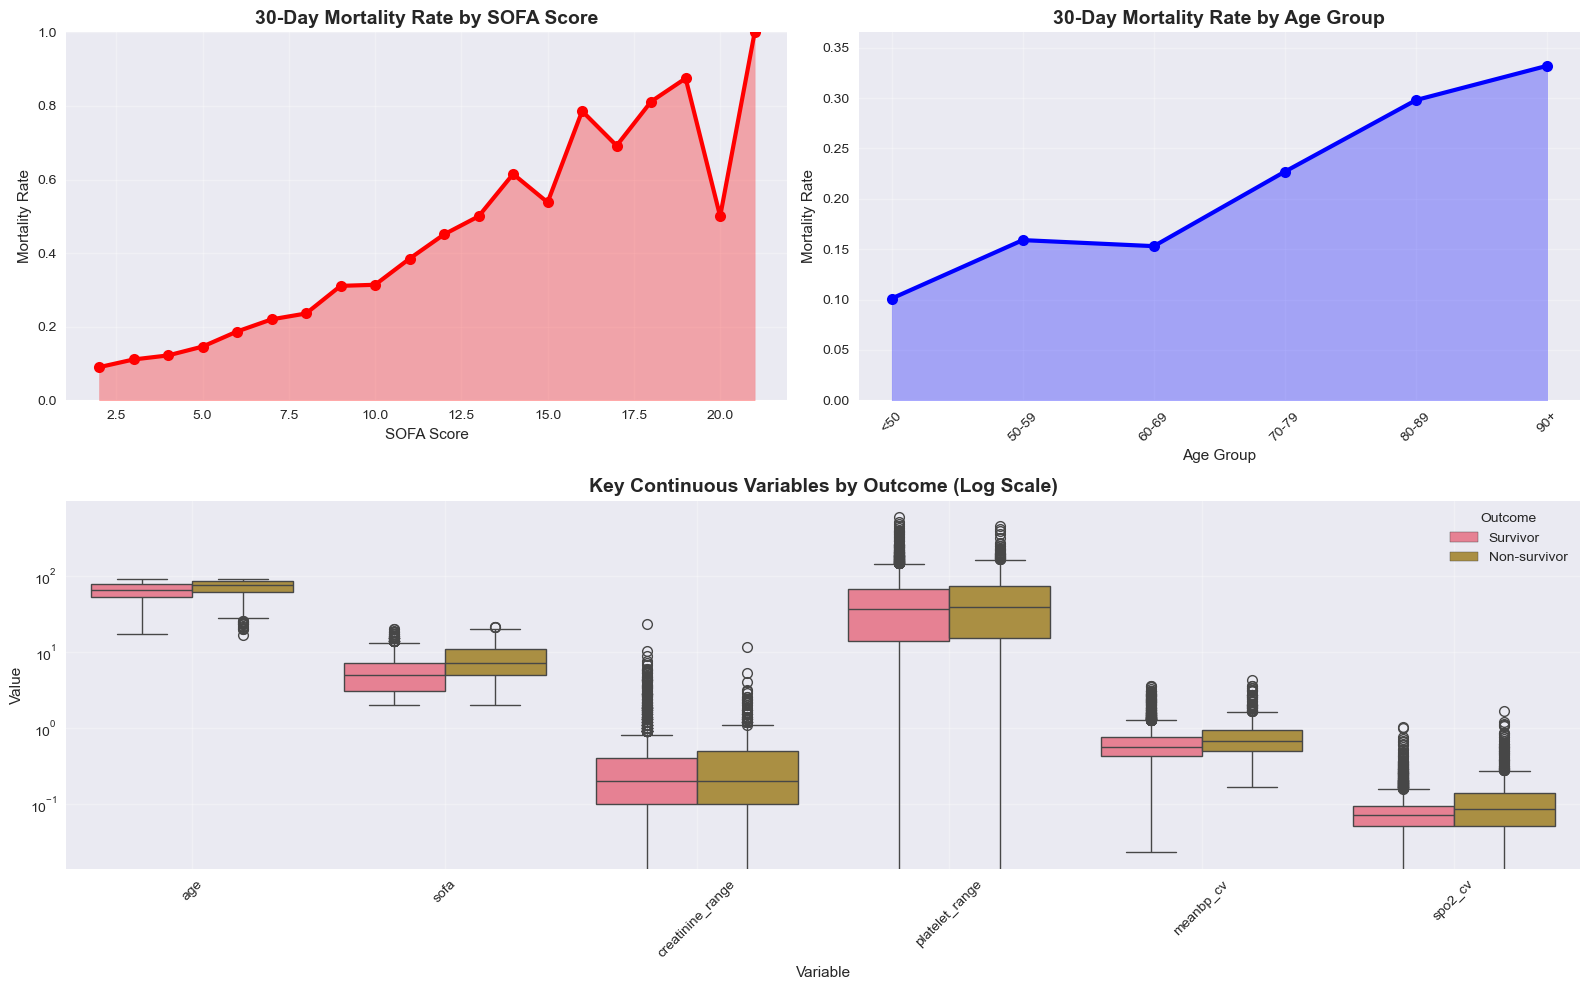

In [56]:
# 1. Mortality Rate by SOFA
sofa_mortality = df.groupby('sofa')['thirtyday_expire_flag'].agg(['count', 'mean']).round(3)

# 2. Mortality Rate by Age Group
age_bins = [0, 50, 60, 70, 80, 90, 100]
age_labels = ['<50', '50-59', '60-69', '70-79', '80-89', '90+']
df['age_group'] = pd.cut(df['age'], bins=age_bins, labels=age_labels, right=False)
age_mortality = df.groupby('age_group')['thirtyday_expire_flag'].agg(['count', 'mean']).round(3)
age_mortality = age_mortality[age_mortality['count'] >= 10]

# 3. Prepare data for boxplots
key_vars = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'meanbp_cv', 'spo2_cv']
plot_data = []

for var in key_vars:
    survivors = df[df['thirtyday_expire_flag'] == 0][var]
    non_survivors = df[df['thirtyday_expire_flag'] == 1][var]
    
    plot_data.extend([{'Variable': var, 'Value': val, 'Outcome': 'Survivor'} for val in survivors])
    plot_data.extend([{'Variable': var, 'Value': val, 'Outcome': 'Non-survivor'} for val in non_survivors])

df_plot = pd.DataFrame(plot_data)

# Create plots
fig = plt.figure(figsize=(16, 10))

# Top row - two plots
ax1 = plt.subplot2grid((2, 2), (0, 0))
ax2 = plt.subplot2grid((2, 2), (0, 1))
# Bottom row - one plot spanning full width
ax3 = plt.subplot2grid((2, 2), (1, 0), colspan=2)

# A. SOFA vs Mortality
ax1.plot(sofa_mortality.index, sofa_mortality['mean'], 'o-', color='red', linewidth=3, markersize=8)
ax1.fill_between(sofa_mortality.index, sofa_mortality['mean'], alpha=0.3, color='red')
ax1.set_title('30-Day Mortality Rate by SOFA Score', fontsize=14, fontweight='bold')
ax1.set_xlabel('SOFA Score')
ax1.set_ylabel('Mortality Rate')
ax1.set_ylim(0, 1)
ax1.grid(True, alpha=0.3)

# B. Age vs Mortality
ax2.plot(range(len(age_mortality)), age_mortality['mean'], 'o-', color='blue', linewidth=3, markersize=8)
ax2.fill_between(range(len(age_mortality)), age_mortality['mean'], alpha=0.3, color='blue')
ax2.set_title('30-Day Mortality Rate by Age Group', fontsize=14, fontweight='bold')
ax2.set_xlabel('Age Group')
ax2.set_ylabel('Mortality Rate')
ax2.set_xticks(range(len(age_mortality)))
ax2.set_xticklabels(age_mortality.index, rotation=45)
ax2.set_ylim(0, max(age_mortality['mean']) * 1.1)
ax2.grid(True, alpha=0.3)

# C. Boxplots spanning full width
sns.boxplot(data=df_plot, x='Variable', y='Value', hue='Outcome', ax=ax3)
ax3.set_yscale('log')
ax3.set_title('Key Continuous Variables by Outcome (Log Scale)', fontsize=14, fontweight='bold')
ax3.tick_params(axis='x', rotation=45)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

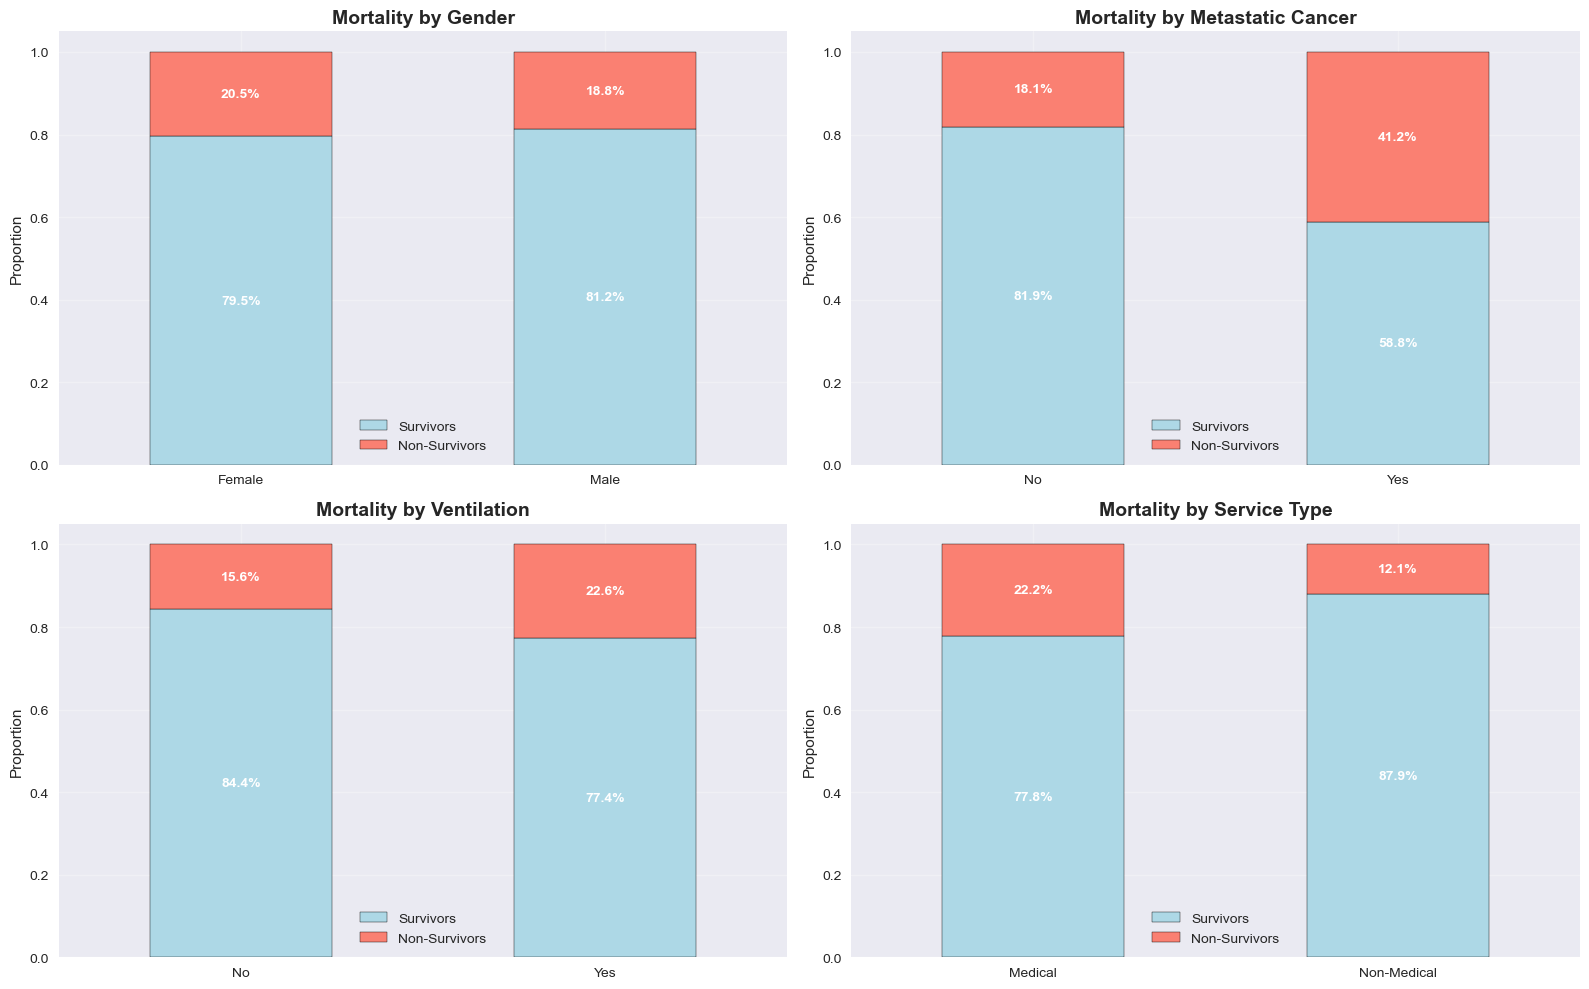

In [57]:
binary_vars = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']

# Convert binary variables to readable labels
df['Gender'] = df['is_male'].map({1: 'Male', 0: 'Female'})
df['Metastatic Cancer'] = df['metastatic_cancer'].map({1: 'Yes', 0: 'No'})
df['Ventilation'] = df['vent'].map({1: 'Yes', 0: 'No'})
df['Service Type'] = df['is_medical'].map({1: 'Medical', 0: 'Non-Medical'})

# Map display variables
cat_display_vars = ['Gender', 'Metastatic Cancer', 'Ventilation', 'Service Type']

# Create plots
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

for ax, var in zip(axes.flatten(), cat_display_vars):
    ct = pd.crosstab(df[var], df['thirtyday_expire_flag'], normalize='index')
    ct.plot(kind='bar', stacked=True, ax=ax, color=['lightblue', 'salmon'], edgecolor='black')
    ax.set_title(f'Mortality by {var}', fontsize=14, fontweight='bold')
    ax.set_ylabel('Proportion')
    ax.legend(['Survivors', 'Non-Survivors'])
    ax.set_xlabel('')
    ax.grid(True, alpha=0.3)
    ax.tick_params(axis='x', rotation=0)
    
    # Add percentage labels on bars
    for container in ax.containers:
        # Convert proportions to percentages by multiplying by 100
        labels = [f'{v.get_height()*100:.1f}%' if v.get_height() > 0.02 else '' 
                 for v in container]
        ax.bar_label(container, labels=labels, label_type='center', 
                    fontweight='bold', fontsize=10, color='white')

plt.tight_layout()
plt.show()
df = df.drop(columns=['service_type', 'age_group', 'Gender', 'Metastatic Cancer', 'Ventilation'], errors='ignore')

### **Statistical Analysis - Testing with Mortality**

In [58]:
# Define variables
continuous_vars = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'meanbp_cv', 'spo2_cv']
categorical_vars = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']

# Initialize results list
results = []

# Define survivors and non-survivors
survivors = df[df['thirtyday_expire_flag'] == 0]
non_survivors = df[df['thirtyday_expire_flag'] == 1]

# Test continuous variables
for var in continuous_vars:
    surv_data = survivors[var]
    non_surv_data = non_survivors[var]
    
    # Test for normality
    _, p_norm_surv = stats.shapiro(surv_data)
    _, p_norm_non = stats.shapiro(non_surv_data)
    
    # Choose test
    if p_norm_surv > 0.05 and p_norm_non > 0.05:
        _, p_value = stats.ttest_ind(surv_data, non_surv_data, equal_var=False)
        test_type = 't-test'
    else:
        _, p_value = stats.mannwhitneyu(surv_data, non_surv_data, alternative='two-sided')
        test_type = 'Mann-Whitney U'
    
    results.append({
        'Variable': var,
        'Test': test_type,
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Test categorical variables - Chi-square only
for var in categorical_vars:
    contingency = pd.crosstab(df[var], df['thirtyday_expire_flag'])
    _, p_value, _, _ = stats.chi2_contingency(contingency)
    
    results.append({
        'Variable': var,
        'Test': 'Chi-square',
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Create and format final results table
results_df = pd.DataFrame(results).sort_values('P_Value').reset_index(drop=True)
results_df['P_Value'] = results_df['P_Value'].apply(lambda x: f"{x:.2e}")
results_df

,Variable,Test,P_Value,Significant
0,sofa,Mann-Whitney U,1.98e-73,Yes
1,age,Mann-Whitney U,8.64e-34,Yes
2,meanbp_cv,Mann-Whitney U,2.76e-27,Yes
3,spo2_cv,Mann-Whitney U,8.30e-26,Yes
4,metastatic_cancer,Chi-square,1.30e-20,Yes
5,is_medical,Chi-square,3.15e-14,Yes
6,vent,Chi-square,3.12e-09,Yes
7,creatinine_range,Mann-Whitney U,3.83e-08,Yes
8,platelet_range,Mann-Whitney U,1.75e-02,Yes
9,is_male,Chi-square,1.56e-01,No


### **Data Preparation for Machine Learning Models**

In [59]:
binary_cols = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']
continuous_cols = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'meanbp_cv', 'spo2_cv']

# Target variable
y = df['thirtyday_expire_flag']
X = df.drop('thirtyday_expire_flag', axis=1)

# Train-test split FIRST to prevent data leakage
X_train_raw, X_test_raw, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Simple approach - scale only continuous variables
scaler = RobustScaler()

# Scale continuous variables
X_train_continuous_scaled = scaler.fit_transform(X_train_raw[continuous_cols])
X_test_continuous_scaled = scaler.transform(X_test_raw[continuous_cols])

# Combine scaled continuous + original binary
X_train_processed = pd.concat([
    pd.DataFrame(X_train_continuous_scaled, columns=continuous_cols, index=X_train_raw.index),
    X_train_raw[binary_cols]
], axis=1)

X_test_processed = pd.concat([
    pd.DataFrame(X_test_continuous_scaled, columns=continuous_cols, index=X_test_raw.index),
    X_test_raw[binary_cols]
], axis=1)

### **K-Means - Optimal Number of Clusters Determination**

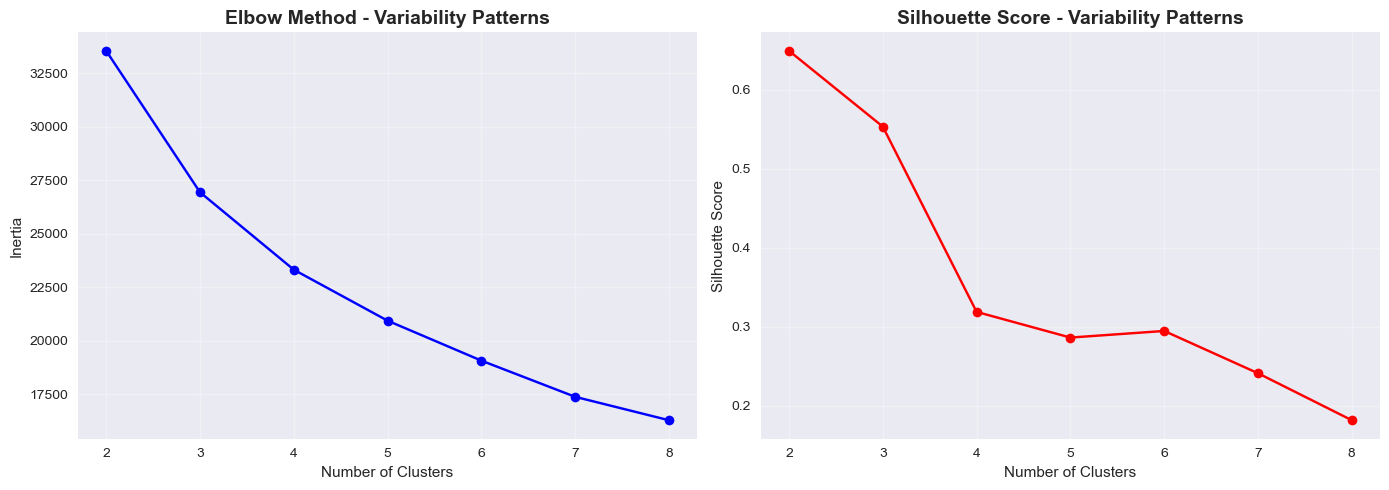

In [60]:
# Use processed training data for clustering
X_cluster = X_train_processed

# Determine optimal number of clusters
max_clusters = 8
inertias = []
silhouette_scores = []

for k in range(2, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_cluster)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_cluster, cluster_labels))

# Plot cluster evaluation
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(2, max_clusters + 1), inertias, 'bo-')
axes[0].set_title('Elbow Method - Variability Patterns', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(2, max_clusters + 1), silhouette_scores, 'ro-')
axes[1].set_title('Silhouette Score - Variability Patterns', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Based on the Elbow Method and Silhouette Score analysis, K=3 was selected as the optimal number of clusters, showing the best balance between cluster cohesion and separation.

### **K-Means PCA Visualization - 2D,3D**

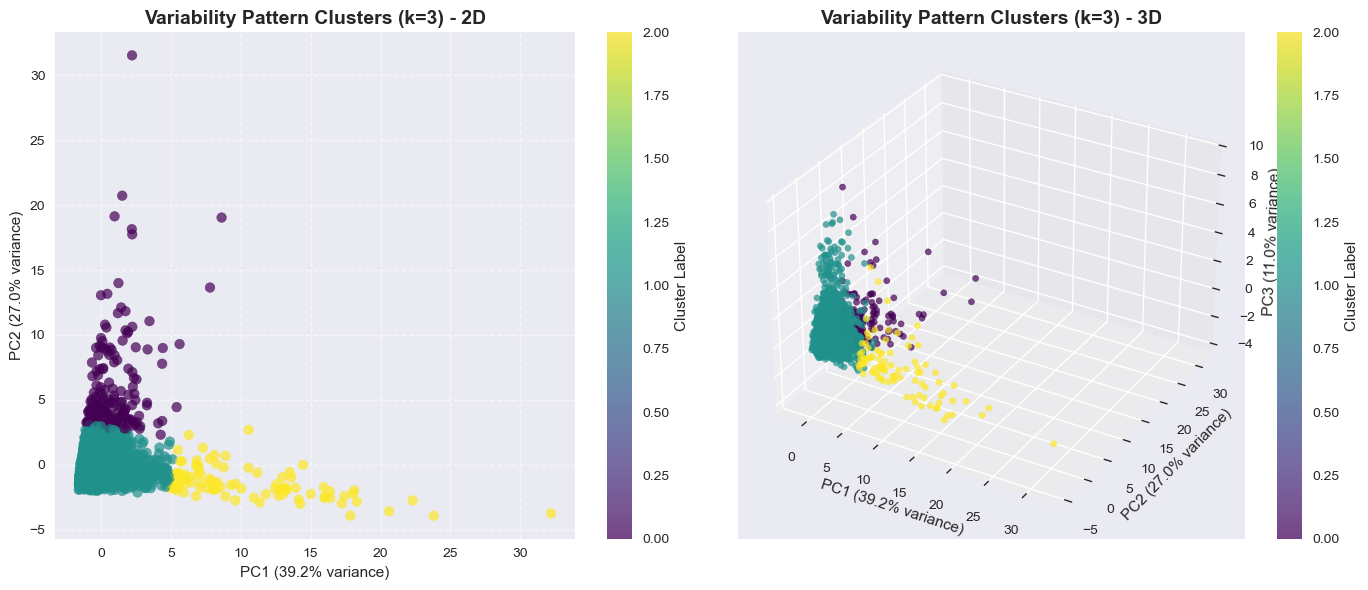

In [61]:
optimal_k = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
variability_labels = kmeans.fit_predict(X_cluster)

# Apply PCA for dimensionality reduction
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_cluster)

# Create visualization
fig = plt.figure(figsize=(14, 6))

# 2D Plot
ax2d = fig.add_subplot(121)
scatter2d = ax2d.scatter(X_pca[:, 0], X_pca[:, 1], c=variability_labels, cmap='viridis', alpha=0.7)
ax2d.set_title(f'Variability Pattern Clusters (k={optimal_k}) - 2D', fontsize=14, fontweight='bold')
ax2d.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2d.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter2d, label='Cluster Label', ax=ax2d)
ax2d.grid(True, linestyle='--', alpha=0.6)

# 3D Plot
ax3d = fig.add_subplot(122, projection='3d')
scatter3d = ax3d.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=variability_labels, cmap='viridis', alpha=0.7)
ax3d.set_title(f'Variability Pattern Clusters (k={optimal_k}) - 3D', fontsize=14, fontweight='bold')
ax3d.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax3d.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax3d.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
plt.colorbar(scatter3d, label='Cluster Label', ax=ax3d)

plt.tight_layout()
plt.show()

### **Agglomerative Clustering - Optimal K Selection via Silhouette Score and Dendrogram**

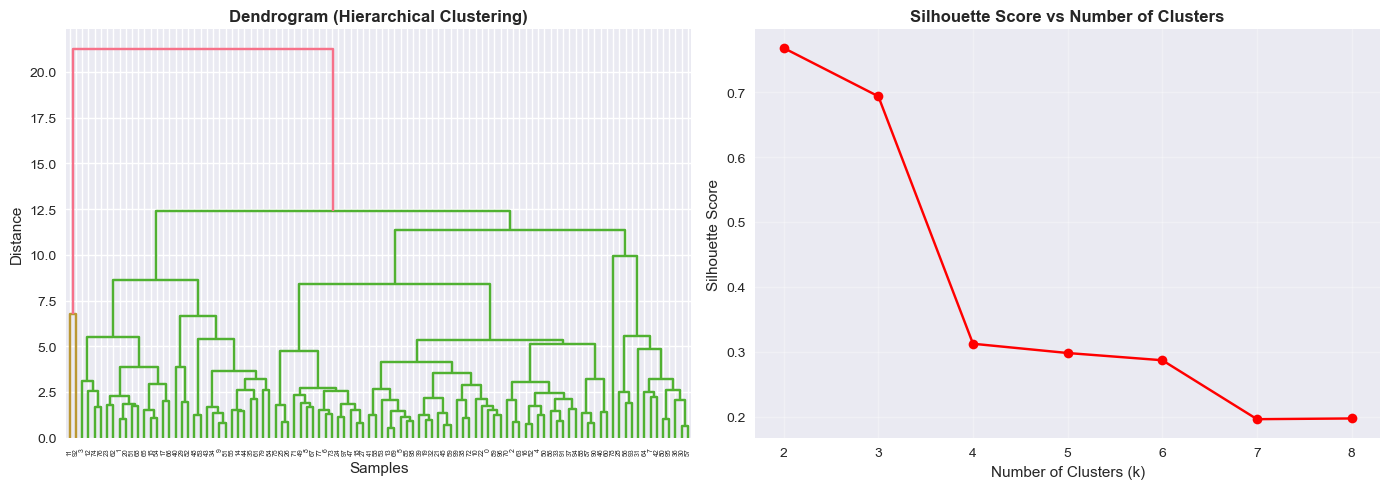

In [62]:
# Agglomerative clustering evaluation
silhouette_scores_agg = []

for k in range(2, max_clusters + 1):
    agg_clustering = AgglomerativeClustering(n_clusters=k, linkage='ward')
    cluster_labels = agg_clustering.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, cluster_labels)
    silhouette_scores_agg.append(score)

# Compute linkage matrix for dendrogram (sample for visualization)
sample_size = min(100, len(X_cluster))
sample_idx = np.random.choice(len(X_cluster), sample_size, replace=False)
Z = linkage(X_cluster.iloc[sample_idx], method='ward')

# Combined plot: Dendrogram + Silhouette Score
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
dendrogram(Z)
plt.title('Dendrogram (Hierarchical Clustering)', fontsize=12, fontweight='bold')
plt.xlabel('Samples')
plt.ylabel('Distance')

plt.subplot(1, 2, 2)
plt.plot(range(2, max_clusters + 1), silhouette_scores_agg, 'ro-')
plt.title('Silhouette Score vs Number of Clusters', fontsize=12, fontweight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()



**K=3** was selected as the optimal number of clusters where clusters remain well-distinguished:
* **Silhouette plot** shows that the silhouette score for K=3 is high (0.7), indicating relatively distinct and clear clusters. Beyond 3, the score drops significantly — meaning further splitting becomes less meaningful.
* **In the dendrogram**, we observe that at a relatively high level, the split into three groups occurs — suggesting that K=3 preserves the natural separation between significant groups in the data.

### **Agglomerative Clustering  PCA Visualization -  2D,3D**

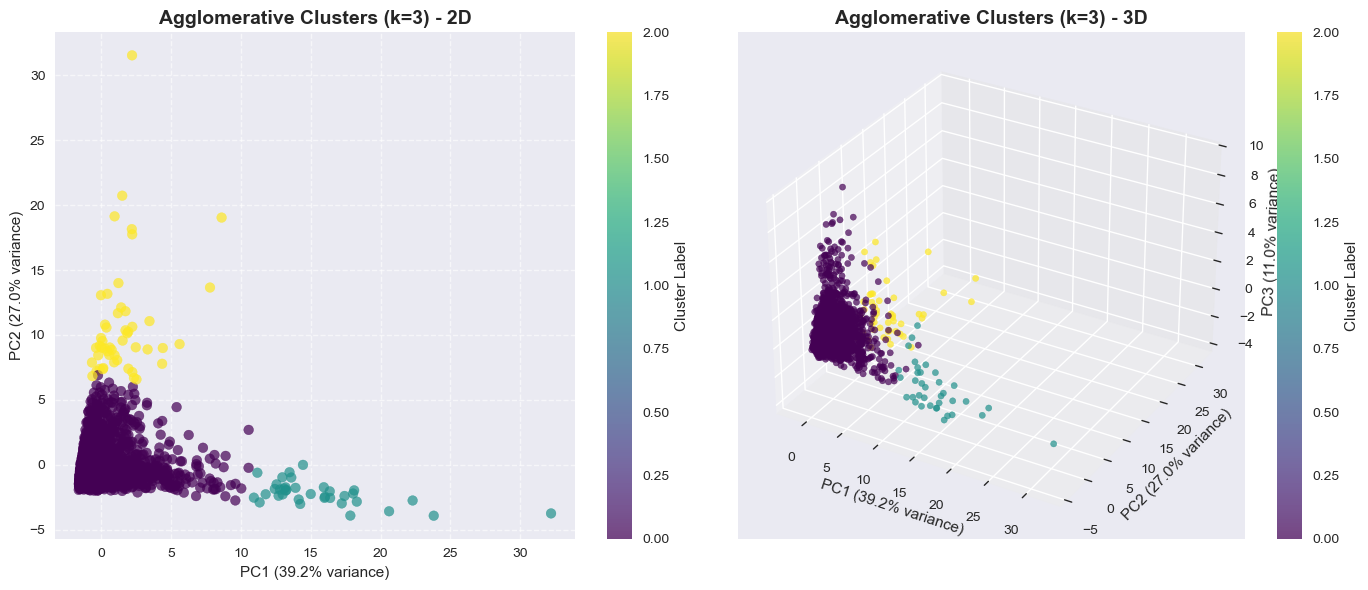

In [63]:
# Apply Agglomerative Clustering with optimal k
optimal_k = 3
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_cluster)

# PCA Visualization for Agglomerative Clustering
fig = plt.figure(figsize=(14, 6))

# 2D Plot for Agglomerative
ax2d = fig.add_subplot(121)
scatter2d = ax2d.scatter(X_pca[:, 0], X_pca[:, 1], c=agg_labels, cmap='viridis', alpha=0.7)
ax2d.set_title(f'Agglomerative Clusters (k={optimal_k}) - 2D', fontsize=14, fontweight='bold')
ax2d.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax2d.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter2d, label='Cluster Label', ax=ax2d)
ax2d.grid(True, linestyle='--', alpha=0.6)

# 3D Plot for Agglomerative
ax3d = fig.add_subplot(122, projection='3d')
scatter3d = ax3d.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=agg_labels, cmap='viridis', alpha=0.7)
ax3d.set_title(f'Agglomerative Clusters (k={optimal_k}) - 3D', fontsize=14, fontweight='bold')
ax3d.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
ax3d.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
ax3d.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]:.1%} variance)')
plt.colorbar(scatter3d, label='Cluster Label', ax=ax3d)

plt.tight_layout()
plt.show()

### **Clustering Methods Performance Comparison**

In [64]:
# Calculate metrics for both algorithms
agg_sil = silhouette_score(X_cluster, agg_labels)
kmeans_sil = silhouette_score(X_cluster, variability_labels)

agg_ch = calinski_harabasz_score(X_cluster, agg_labels)
kmeans_ch = calinski_harabasz_score(X_cluster, variability_labels)

agg_db = davies_bouldin_score(X_cluster, agg_labels)  # Lower is better
kmeans_db = davies_bouldin_score(X_cluster, variability_labels)  # Lower is better

# Create comparison table
comparison = pd.DataFrame({
    'Silhouette': [agg_sil, kmeans_sil],
    'Calinski-Harabasz': [agg_ch, kmeans_ch], 
    'Davies-Bouldin': [agg_db, kmeans_db]
}, index=['Agglomerative', 'K-Means']).round(4)

comparison



,Silhouette,Calinski-Harabasz,Davies-Bouldin
Agglomerative,0.6934,954.7293,0.5746
K-Means,0.5535,1150.5835,0.9121


Agglomerative clustering was selected based on superior performance in 2 out of 3 evaluation metrics:
- **Higher Silhouette score** (0.693 vs 0.553): Better cluster separation and cohesion
- **Lower Davies-Bouldin score** (0.574 vs 0.912): Reduced cluster overlap and better-defined boundaries
- K-Means only outperformed in Calinski-Harabasz score, but the overall evidence favors Agglomerative clustering for more distinct and clinically meaningful patient subgroups.

### **Cluster Assignment and Prediction for Train/Test Sets**

To prevent data leakage, clustering was performed only on training data, then a Random Forest classifier was trained to predict cluster membership for the test set. This ensures that clustering patterns discovered in training data can be consistently applied to new, unseen data.

In [65]:
# Apply Agglomerative clustering on training data only
chosen_labels = agg_clustering.fit_predict(X_train_processed)

# Train a cluster predictor on training data
cluster_predictor = RandomForestClassifier(random_state=42)
cluster_predictor.fit(X_train_processed, chosen_labels)

# Predict clusters for both training and test data using the trained model
train_clusters = cluster_predictor.predict(X_train_processed)
test_clusters = cluster_predictor.predict(X_test_processed)

# Add predicted cluster labels (not original!) to data
X_train_with_clusters = X_train_raw.copy()
X_train_with_clusters['Cluster'] = train_clusters
X_train_with_clusters['thirtyday_expire_flag'] = y_train

X_test_raw_with_clusters = X_test_raw.copy()
X_test_raw_with_clusters['Cluster'] = test_clusters

# Print distributions
print("Training Cluster distribution:")
print(pd.Series(train_clusters).value_counts().sort_index())

print("Test Cluster distribution:")
print(pd.Series(test_clusters).value_counts().sort_index())


Training Cluster distribution:
0    3561
1      36
2      50
Name: count, dtype: int64
Test Cluster distribution:
0    894
1      7
2     11
Name: count, dtype: int64


### **Cluster Characterization - Continuous Variables Analysis**

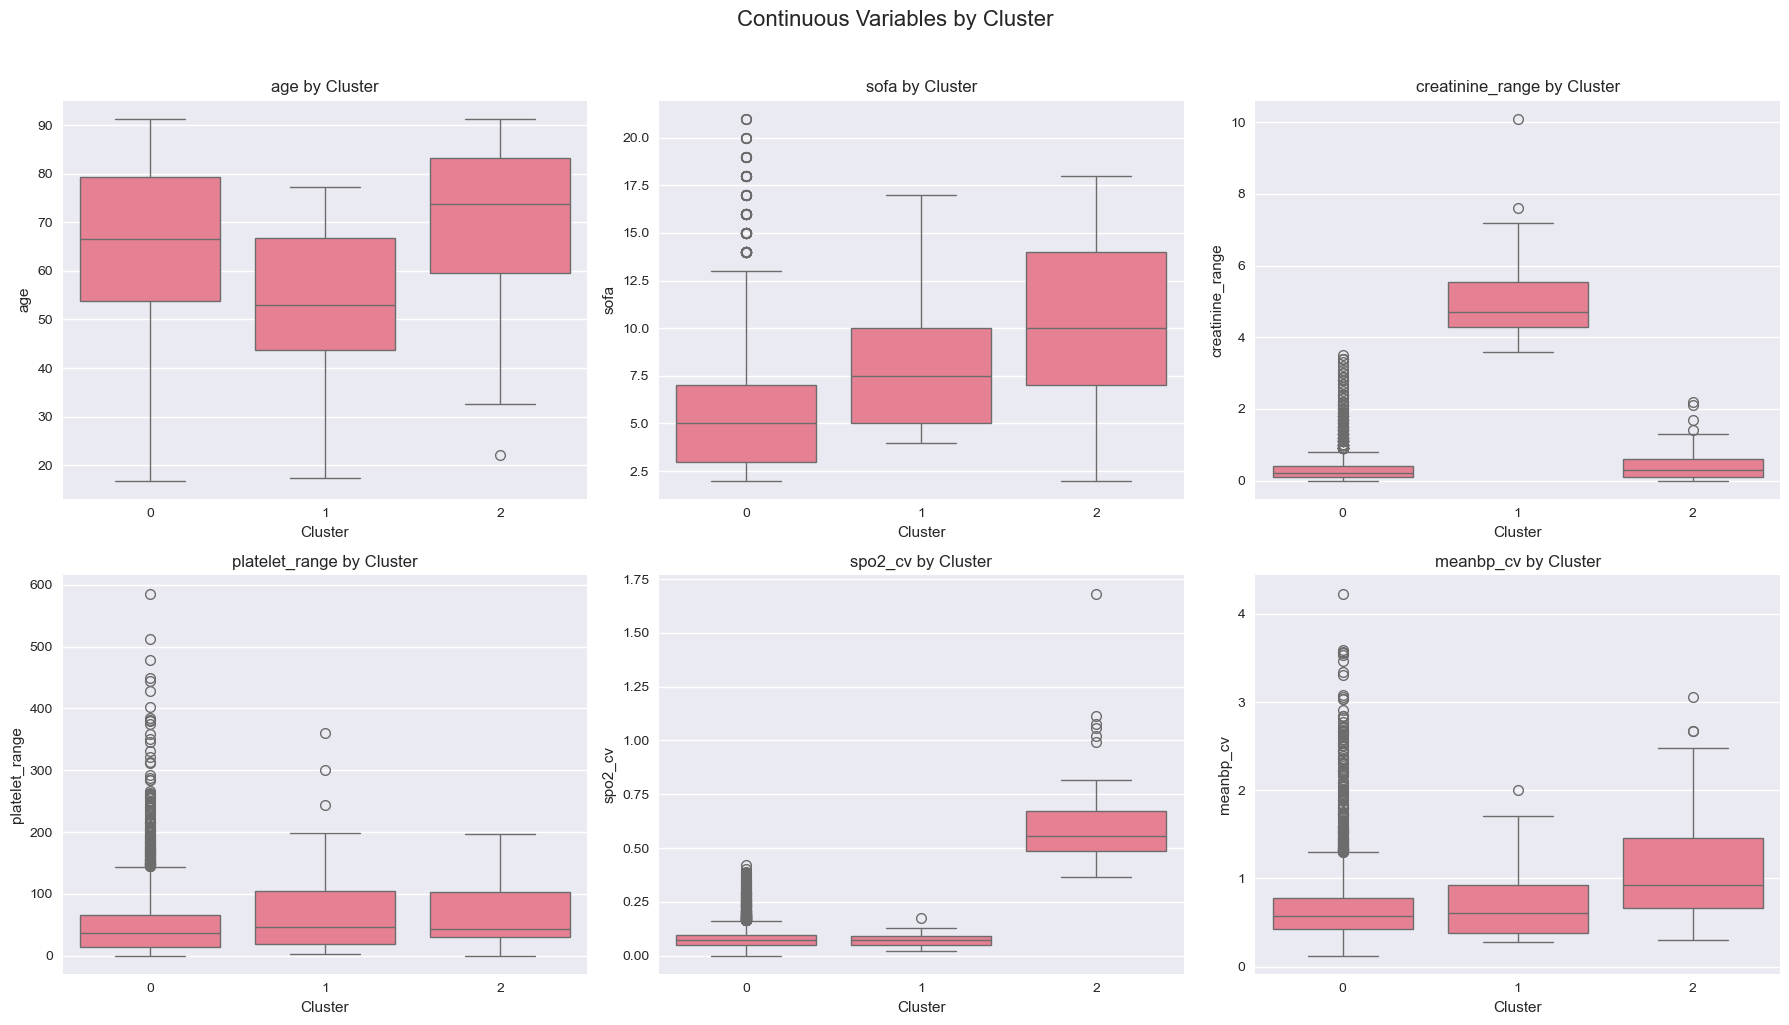

In [66]:
# Identify variables for analysis
continuous_vars = ['age', 'sofa', 'creatinine_range', 
                   'platelet_range', 'spo2_cv', 'meanbp_cv']

# Create boxplots for continuous variables - 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(continuous_vars):
    sns.boxplot(data=X_train_with_clusters, x='Cluster', y=col, ax=axes[i])
    axes[i].set_title(f'{col} by Cluster')

plt.suptitle('Continuous Variables by Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **Cluster Characterization - Categorical Variables Analysis**

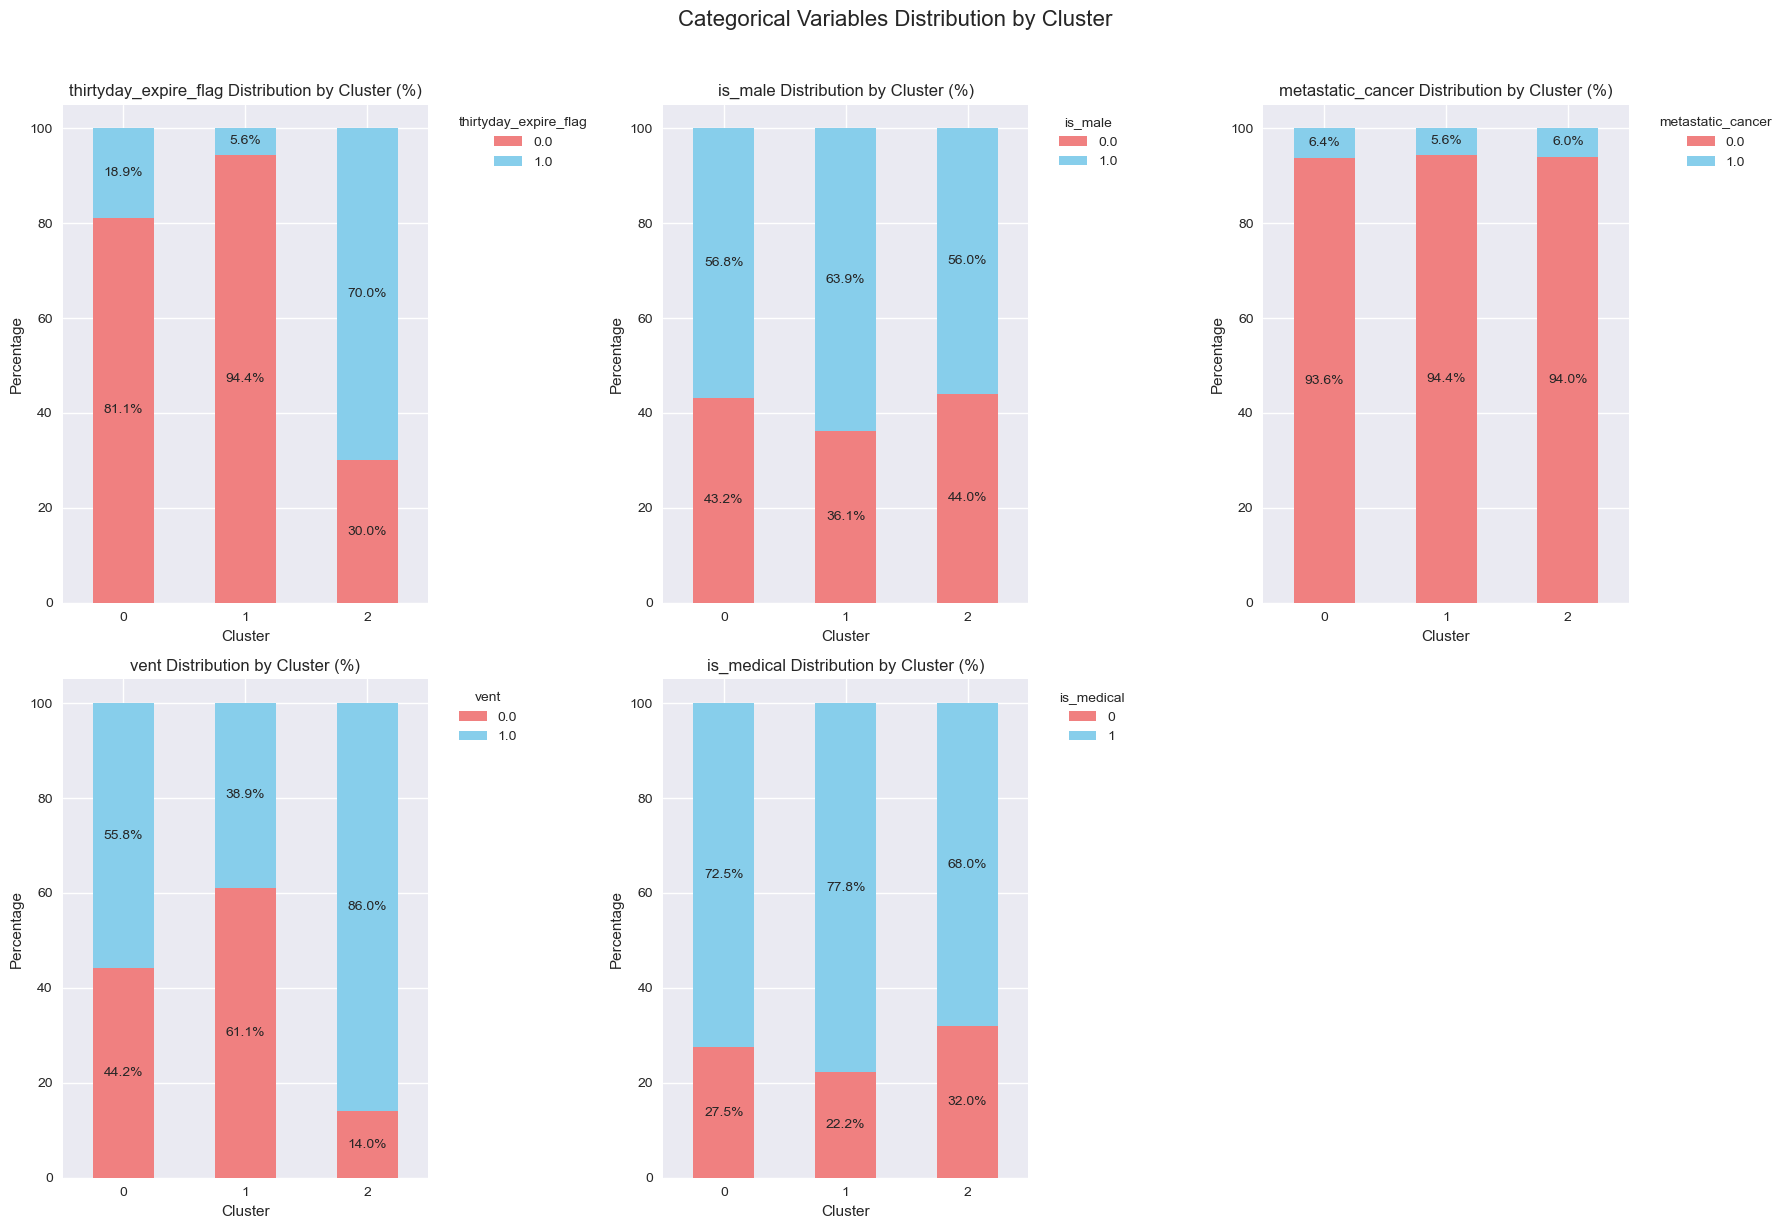

In [67]:
# Categorical/binary variables
binary_vars = ['thirtyday_expire_flag', 'is_male', 'metastatic_cancer', 'vent', 'is_medical']

# Create percentage bar charts - 2 rows, 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(binary_vars):
    # Calculate percentages within each cluster
    crosstab = pd.crosstab(X_train_with_clusters['Cluster'], X_train_with_clusters[col], normalize='index') * 100
    
    # Create stacked bar chart
    crosstab.plot(kind='bar', ax=axes[i], stacked=True, 
                 color=['lightcoral', 'skyblue', 'lightgreen', 'orange'][:len(crosstab.columns)])
    axes[i].set_title(f'{col} Distribution by Cluster (%)')
    axes[i].set_xlabel('Cluster')
    axes[i].set_ylabel('Percentage')
    axes[i].legend(title=col, bbox_to_anchor=(1.05, 1), loc='upper left')
    axes[i].tick_params(axis='x', rotation=0)
    
    # Add percentage labels on bars
    for container in axes[i].containers:
        axes[i].bar_label(container, fmt='%.1f%%', label_type='center')

# Hide the last empty subplot
axes[5].set_visible(False)

plt.suptitle('Categorical Variables Distribution by Cluster', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

### **Statistical Testing of Cluster Differences**

In [68]:
# Initialize results
results = []

# Test continuous variables - Kruskal-Wallis
for col in continuous_vars:
    cluster_groups = [X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster][col].values 
                      for cluster in sorted(X_train_with_clusters['Cluster'].unique())]
    
    statistic, p_value = kruskal(*cluster_groups)
    
    results.append({
        'Variable': col,
        'Test': 'Kruskal-Wallis',
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Test categorical variables - Chi-Square
for col in binary_vars:
    contingency_table = pd.crosstab(X_train_with_clusters['Cluster'], X_train_with_clusters[col])
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)
    
    results.append({
        'Variable': col,
        'Test': 'Chi-Square',
        'P_Value': p_value,
        'Significant': 'Yes' if p_value < 0.05 else 'No'
    })

# Create final table
results_df = pd.DataFrame(results).sort_values('P_Value').reset_index(drop=True)
results_df['P_Value'] = results_df['P_Value'].apply(lambda x: f"{x:.2e}")
results_df


,Variable,Test,P_Value,Significant
0,spo2_cv,Kruskal-Wallis,7.76e-33,Yes
1,creatinine_range,Kruskal-Wallis,1.01e-24,Yes
2,thirtyday_expire_flag,Chi-Square,1.69e-19,Yes
3,sofa,Kruskal-Wallis,3.03e-18,Yes
4,meanbp_cv,Kruskal-Wallis,2.20e-08,Yes
5,vent,Chi-Square,1.23e-05,Yes
6,age,Kruskal-Wallis,3.58e-05,Yes
7,platelet_range,Kruskal-Wallis,1.66e-02,Yes
8,is_medical,Chi-Square,6.03e-01,No
9,is_male,Chi-Square,6.86e-01,No


### **Detailed Cluster Characterization - Descriptive Statistics**

In [69]:
print("CLINICAL CLUSTER CHARACTERIZATION")
print("="*45)
print("Statistically significant variables only (p<0.05)")
print()

# =============================================================================
# A. CONTINUOUS VARIABLES SUMMARY
# =============================================================================

print("A. CONTINUOUS VARIABLES")
print("-"*25)

# Significant continuous variables
continuous_vars = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'spo2_cv', 'meanbp_cv']

# Create individual tables for each cluster
for cluster_id in sorted(X_train_with_clusters['Cluster'].unique()):
    cluster_data = X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster_id]
    
    print(f"\nCLUSTER {cluster_id} (n={len(cluster_data)})")
    print("-" * 45)
    
    # Create summary table for this cluster
    cluster_summary = []
    for var in continuous_vars:
        var_data = cluster_data[var]
        
        # Determine appropriate decimal places
        if var in ['age', 'sofa']:
            decimals = 1
        elif var in ['creatinine_range', 'platelet_range']:
            decimals = 1
        else:  # CV variables
            decimals = 3
        
        cluster_summary.append({
            'Variable': var,
            'Mean': round(var_data.mean(), decimals),
            'Median': round(var_data.median(), decimals),
            'Q25': round(var_data.quantile(0.25), decimals),
            'Q75': round(var_data.quantile(0.75), decimals)
        })
    
    # Convert to DataFrame and display with better formatting
    cluster_df = pd.DataFrame(cluster_summary)
    print(cluster_df.to_string(index=False, col_space=10))

# =============================================================================
# B. CATEGORICAL VARIABLES SUMMARY
# =============================================================================

print(f"\n\nB. CATEGORICAL VARIABLES")
print("-"*25)

# Significant categorical variables
categorical_vars = ['thirtyday_expire_flag', 'vent']

# Create unified categorical summary table
categorical_data = []
for cluster_id in sorted(X_train_with_clusters['Cluster'].unique()):
    cluster_subset = X_train_with_clusters[X_train_with_clusters['Cluster'] == cluster_id]
    cluster_size = len(cluster_subset)
    
    row_data = {'Cluster': cluster_id, 'N': cluster_size}
    
    # 30-day mortality
    mortality_count = cluster_subset['thirtyday_expire_flag'].sum()
    mortality_pct = (mortality_count / cluster_size) * 100
    row_data['Mortality_n'] = mortality_count
    row_data['Mortality_%'] = round(mortality_pct, 1)
    
    # Mechanical ventilation
    vent_count = cluster_subset['vent'].sum()
    vent_pct = (vent_count / cluster_size) * 100
    row_data['Ventilated_n'] = vent_count
    row_data['Ventilated_%'] = round(vent_pct, 1)
    
    categorical_data.append(row_data)

categorical_df = pd.DataFrame(categorical_data)

print("\nCategorical Variables Summary:")
print(categorical_df[['Cluster', 'N', 'Mortality_n', 'Mortality_%', 'Ventilated_n', 'Ventilated_%']].to_string(index=False))



CLINICAL CLUSTER CHARACTERIZATION
Statistically significant variables only (p<0.05)

A. CONTINUOUS VARIABLES
-------------------------

CLUSTER 0 (n=3561)
---------------------------------------------
        Variable       Mean     Median        Q25        Q75
             age     65.100     66.600     53.800     79.300
            sofa      5.700      5.000      3.000      7.000
creatinine_range      0.300      0.200      0.100      0.400
  platelet_range     49.100     36.000     14.000     66.000
         spo2_cv      0.082      0.072      0.051      0.096
       meanbp_cv      0.670      0.572      0.431      0.778

CLUSTER 1 (n=36)
---------------------------------------------
        Variable       Mean     Median        Q25        Q75
             age     53.400     52.900     43.800     66.900
            sofa      8.200      7.500      5.000     10.000
creatinine_range      5.100      4.700      4.300      5.600
  platelet_range     78.200     46.500     19.500    104.500
   

### **Clinical Cluster Interpretation Summary**

Unsupervised clustering identified **three distinct patient subgroups** with statistically significant differences across key physiological variables (p<0.05 for most features via Kruskal-Wallis and Chi-Square tests).

---

#### **Cluster 2 – High Severity Profile**
- **Highest values**: Age, SOFA scores, SpO₂ variability, creatinine range
- **Highest rates**: Ventilation usage (~86%) and 30-day mortality (~70%)
- **Characterized by**: Advanced age with multiple organ system instability

---

####  **Cluster 1 – Young High-Creatinine Profile** 
- **Lowest values**: Age and 30-day mortality (~5.6%)
- **Highest values**: Creatinine range (distinctive feature)
- **Characterized by**: Younger patients with marked renal variability but low mortality

---

####  **Cluster 0 – Intermediate Profile**
- **Moderate values**: All continuous variables fall between other clusters
- **Intermediate rates**: Ventilation (~44%) and mortality (~19%)
- **Characterized by**: Balanced physiological parameters across all measured variables


### **Feature Set Definition and Model Preprocessing**

Creating three distinct feature sets for comparative modeling:
- **Baseline**: Core clinical variables (age, SOFA, demographics)
- **Enhanced**: Baseline + engineered variability metrics
- **Cluster**: Enhanced + cluster membership information

Each feature set uses tailored preprocessing pipelines to ensure consistent scaling and encoding across train/test splits.

In [70]:
# Define feature sets
baseline_features = ['age', 'is_male', 'metastatic_cancer', 'vent', 'sofa', 'is_medical']
enhanced_features = baseline_features + ['creatinine_range', 'platelet_range', 'spo2_cv', 'meanbp_cv']
cluster_features = enhanced_features + ['Cluster']

# Add cluster labels to raw data
X_train_raw['Cluster'] = train_clusters
X_test_raw['Cluster'] = test_clusters

# Initialize scalers
scaler_base = RobustScaler()
scaler_enh = RobustScaler()
scaler_clust = RobustScaler()

# =============================================================================
# BASELINE MODEL
# =============================================================================
continuous_base = ['age', 'sofa']
binary_base = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']

X_train_base_scaled = scaler_base.fit_transform(X_train_raw[continuous_base])
X_test_base_scaled = scaler_base.transform(X_test_raw[continuous_base])

X_train_base = np.column_stack([X_train_base_scaled, X_train_raw[binary_base].values])
X_test_base = np.column_stack([X_test_base_scaled, X_test_raw[binary_base].values])

# =============================================================================
# ENHANCED MODEL  
# =============================================================================
continuous_enh = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'spo2_cv', 'meanbp_cv']
binary_enh = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']

X_train_enh_scaled = scaler_enh.fit_transform(X_train_raw[continuous_enh])
X_test_enh_scaled = scaler_enh.transform(X_test_raw[continuous_enh])

X_train_enh = np.column_stack([X_train_enh_scaled, X_train_raw[binary_enh].values])
X_test_enh = np.column_stack([X_test_enh_scaled, X_test_raw[binary_enh].values])

# =============================================================================
# CLUSTER MODEL
# =============================================================================

continuous_clust = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'spo2_cv', 'meanbp_cv']
binary_clust = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']

# Scale continuous features
X_train_clust_scaled = scaler_clust.fit_transform(X_train_raw[continuous_clust])
X_test_clust_scaled = scaler_clust.transform(X_test_raw[continuous_clust])

# One-hot encode cluster labels
cluster_encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid multicollinearity
cluster_train_encoded = cluster_encoder.fit_transform(X_train_raw[['Cluster']])
cluster_test_encoded = cluster_encoder.transform(X_test_raw[['Cluster']])

# Combine all features
X_train_clust = np.column_stack([
    X_train_clust_scaled,           
    X_train_raw[binary_clust].values,
    cluster_train_encoded          
])

X_test_clust = np.column_stack([
    X_test_clust_scaled,            
    X_test_raw[binary_clust].values,   
    cluster_test_encoded            
])


### **Baseline Models - Hyperparameter Tuning**

In [71]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Logistic Regression - Baseline
lr_params = {'C': [0.01, 0.1, 1, 10], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
lr_grid_base = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                           lr_params, cv=cv, scoring='roc_auc', n_jobs=-1)
lr_grid_base.fit(X_train_base, y_train)

# Random Forest - Baseline  
rf_params = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 20]}
rf_grid_base = GridSearchCV(RandomForestClassifier(random_state=42), 
                           rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_base.fit(X_train_base, y_train)

# XGBoost - Baseline
xgb_params = {'n_estimators': [100, 200, 300], 'max_depth': [3, 6], 'learning_rate': [0.01, 0.1]}
xgb_grid_base = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), 
                            xgb_params, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_grid_base.fit(X_train_base, y_train)

print("BASELINE MODEL TUNING:")
print(f"LR: {lr_grid_base.best_params_} (CV: {lr_grid_base.best_score_:.4f})")
print(f"RF: {rf_grid_base.best_params_} (CV: {rf_grid_base.best_score_:.4f})")
print(f"XGB: {xgb_grid_base.best_params_} (CV: {xgb_grid_base.best_score_:.4f})")

BASELINE MODEL TUNING:
LR: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'} (CV: 0.7539)
RF: {'max_depth': 5, 'n_estimators': 300} (CV: 0.7581)
XGB: {'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300} (CV: 0.7537)


### **Enhanced Models - Hyperparameter Tuning**

In [72]:
# Logistic Regression - Enhanced
lr_grid_enh = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                          lr_params, cv=cv, scoring='roc_auc', n_jobs=-1)
lr_grid_enh.fit(X_train_enh, y_train)

# Random Forest - Enhanced
rf_grid_enh = GridSearchCV(RandomForestClassifier(random_state=42), 
                          rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_enh.fit(X_train_enh, y_train)

# XGBoost - Enhanced
xgb_grid_enh = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), 
                           xgb_params, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_grid_enh.fit(X_train_enh, y_train)
print("\nENHANCED MODEL TUNING:")
print(f"LR: {lr_grid_enh.best_params_} (CV: {lr_grid_enh.best_score_:.4f})")
print(f"RF: {rf_grid_enh.best_params_} (CV: {rf_grid_enh.best_score_:.4f})")
print(f"XGB: {xgb_grid_enh.best_params_} (CV: {xgb_grid_enh.best_score_:.4f})")


ENHANCED MODEL TUNING:
LR: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'} (CV: 0.7671)
RF: {'max_depth': 10, 'n_estimators': 200} (CV: 0.7789)
XGB: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300} (CV: 0.7712)


### **Cluster-Enhanced Models - Hyperparameter Tuning**

In [73]:
# Logistic Regression - Cluster
lr_grid_clust = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000), 
                            lr_params, cv=cv, scoring='roc_auc', n_jobs=-1)
lr_grid_clust.fit(X_train_clust, y_train)

# Random Forest - Cluster
rf_grid_clust = GridSearchCV(RandomForestClassifier(random_state=42), 
                            rf_params, cv=cv, scoring='roc_auc', n_jobs=-1)
rf_grid_clust.fit(X_train_clust, y_train)

# XGBoost - Cluster
xgb_grid_clust = GridSearchCV(xgb.XGBClassifier(random_state=42, eval_metric='logloss'), 
                             xgb_params, cv=cv, scoring='roc_auc', n_jobs=-1)
xgb_grid_clust.fit(X_train_clust, y_train)

print("\nCLUSTER MODEL TUNING:")
print(f"LR: {lr_grid_clust.best_params_} (CV: {lr_grid_clust.best_score_:.4f})")
print(f"RF: {rf_grid_clust.best_params_} (CV: {rf_grid_clust.best_score_:.4f})")
print(f"XGB: {xgb_grid_clust.best_params_} (CV: {xgb_grid_clust.best_score_:.4f})")


CLUSTER MODEL TUNING:
LR: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'} (CV: 0.7667)
RF: {'max_depth': 10, 'n_estimators': 200} (CV: 0.7825)
XGB: {'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 300} (CV: 0.7710)


**Model Selection:** Random Forest was selected for all three model variants (Baseline, Enhanced, Cluster) as it consistently demonstrated the highest cross-validation AUC scores across all feature sets, indicating superior discriminative performance for 30-day mortality prediction.

### **10 Cross-Validation For The 3 Models**

CROSS VALIDATION RESULTS:
             Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  \
Baseline RF  0.7836  0.7747  0.7801  0.7557  0.7972  0.7447  0.7216  0.7679   
Enhanced RF  0.7911  0.7966  0.7893  0.7695  0.7962  0.7855  0.7524  0.7695   
Cluster RF   0.7909  0.7967  0.7893  0.7670  0.7944  0.7892  0.7547  0.7665   

             Fold 9  Fold 10  Mean AUC  
Baseline RF  0.7464   0.7087    0.7581  
Enhanced RF  0.7572   0.7613    0.7769  
Cluster RF   0.7550   0.7667    0.7770  


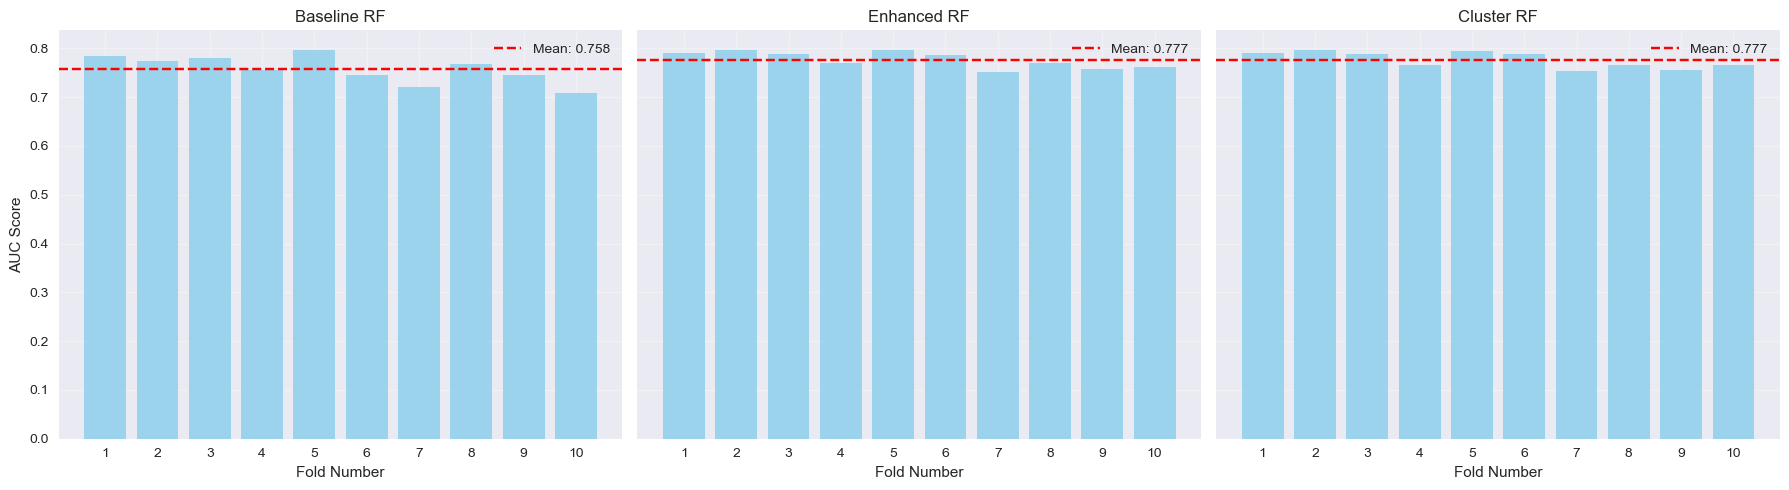

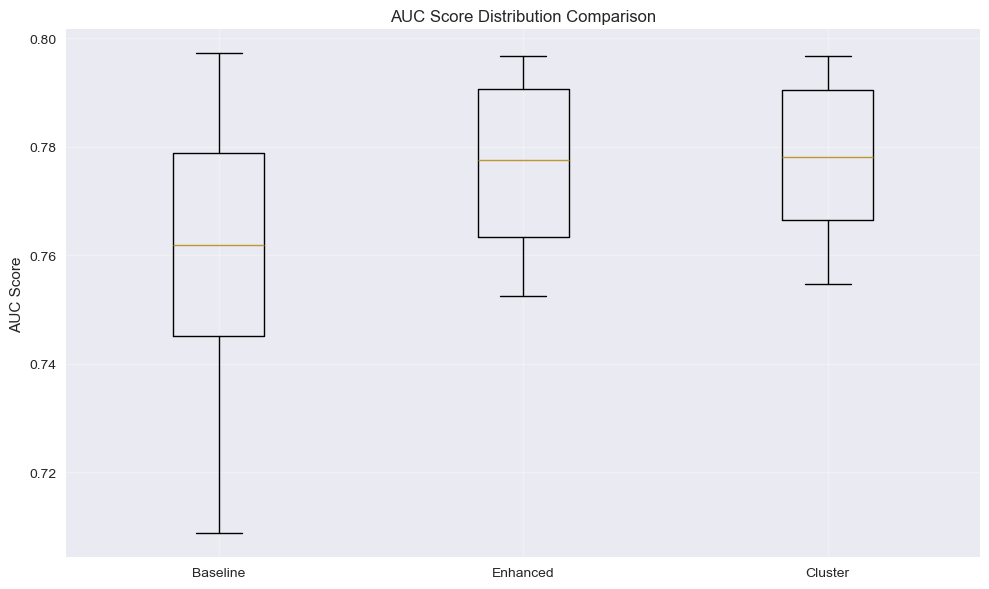

In [74]:
# Use best RF parameters from previous hyperparameter tuning
best_rf_params = rf_grid_base.best_params_

# Create Random Forest models dictionary
models = {
    'Baseline RF': RandomForestClassifier(random_state=42, **best_rf_params),
    'Enhanced RF': RandomForestClassifier(random_state=42, **best_rf_params),
    'Cluster RF': RandomForestClassifier(random_state=42, **best_rf_params)
}

# Data dictionary for each model
model_data = {
    'Baseline RF': (X_train_base, y_train),
    'Enhanced RF': (X_train_enh, y_train),
    'Cluster RF': (X_train_clust, y_train)
}

# Define cross validation strategy
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Perform cross validation for each model
cv_scores_dict = {}

for model_name, model in models.items():
    X_data, y_data = model_data[model_name]
    cv_scores = cross_val_score(model, X_data, y_data, cv=cv, scoring='roc_auc')
    cv_scores_dict[model_name] = cv_scores

# Create results DataFrame
cv_results = pd.DataFrame(cv_scores_dict).T  
cv_results.columns = [f'Fold {i+1}' for i in range(cv_results.shape[1])]  
cv_results['Mean AUC'] = cv_results.mean(axis=1)  

# Display results table
print("CROSS VALIDATION RESULTS:")
print("=" * 60)
print(cv_results.round(4))

# Bar plots for each model
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (model_name, cv_scores) in enumerate(cv_scores_dict.items()):
    axes[i].bar(range(1, len(cv_scores) + 1), cv_scores, color='skyblue', alpha=0.8)
    axes[i].axhline(y=cv_scores.mean(), color='red', linestyle='--', 
                   label=f'Mean: {cv_scores.mean():.3f}')
    axes[i].set_title(model_name)
    axes[i].set_xlabel('Fold Number')
    if i == 0:
        axes[i].set_ylabel('AUC Score')
    axes[i].set_xticks(range(1, len(cv_scores) + 1))
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Box plot comparison
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
box_data = list(cv_scores_dict.values())  # קיצור
box_labels = ['Baseline', 'Enhanced', 'Cluster']
ax.boxplot(box_data, labels=box_labels)
ax.set_title('AUC Score Distribution Comparison')
ax.set_ylabel('AUC Score')
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Test Set Evaluation and Performance Analysis**


MODEL PERFORMANCE COMPARISON (Threshold = 0.1)
      Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC  Specificity
Baseline RF    0.3969     0.2395  0.9607    0.3834    0.758       0.2602
Enhanced RF    0.5055     0.2698  0.8989    0.4150    0.766       0.4101
 Cluster RF    0.5011     0.2703  0.9157    0.4174    0.764       0.4005

MODEL PERFORMANCE COMPARISON (Threshold = 0.15)
      Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC  Specificity
Baseline RF    0.5965     0.3053  0.8371    0.4474    0.758       0.5381
Enhanced RF    0.6283     0.3183  0.7921    0.4541    0.766       0.5886
 Cluster RF    0.6414     0.3279  0.7978    0.4648    0.764       0.6035

MODEL PERFORMANCE COMPARISON (Threshold = 0.2)
      Model  Accuracy  Precision  Recall  F1_Score  ROC_AUC  Specificity
Baseline RF    0.7237     0.3733  0.6124    0.4638    0.758       0.7507
Enhanced RF    0.7127     0.3654  0.6404    0.4653    0.766       0.7302
 Cluster RF    0.6996     0.3462  0.6067    0.4408  

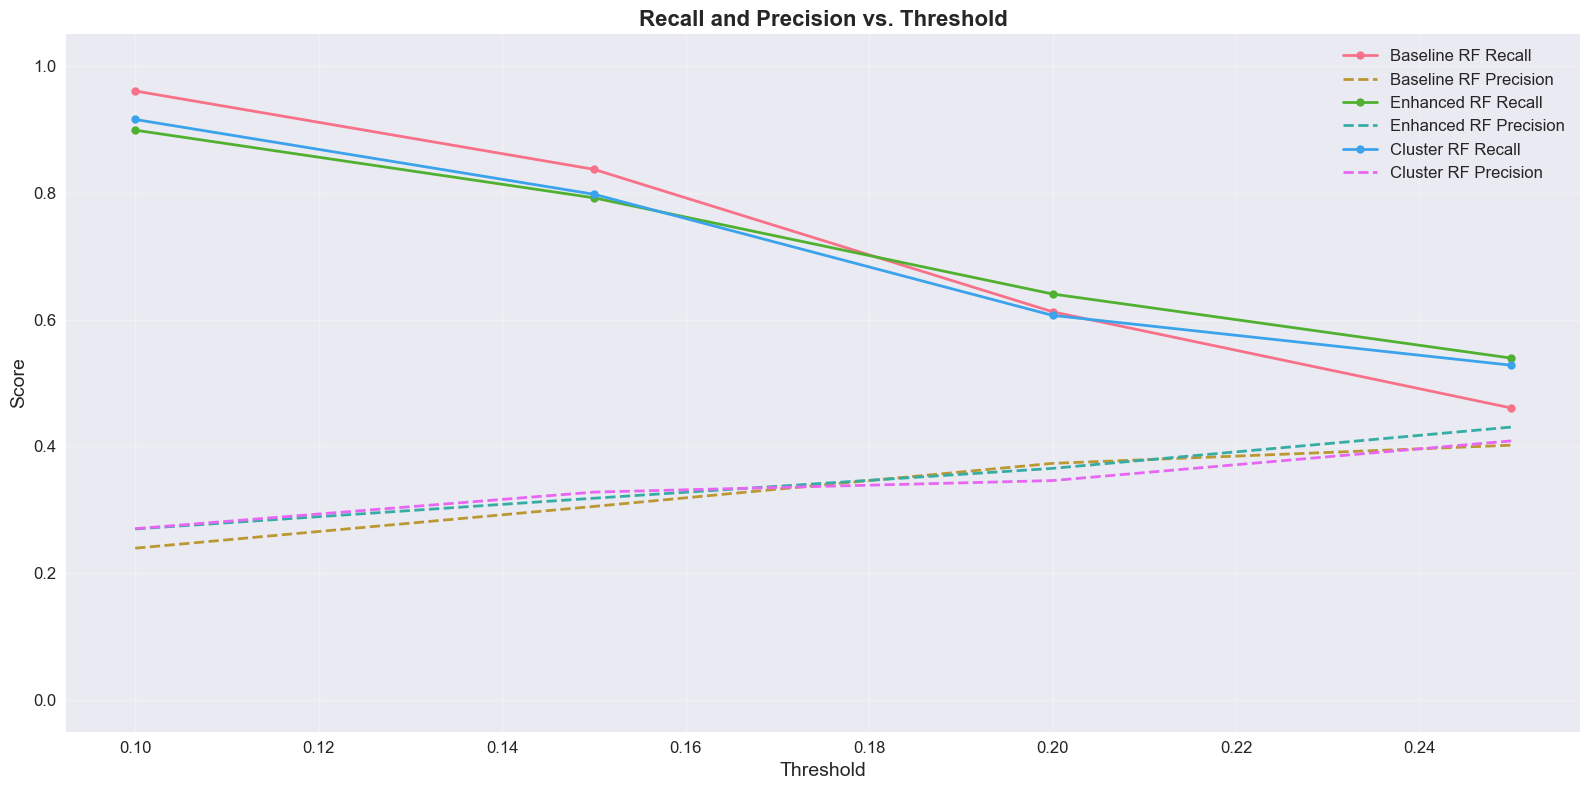

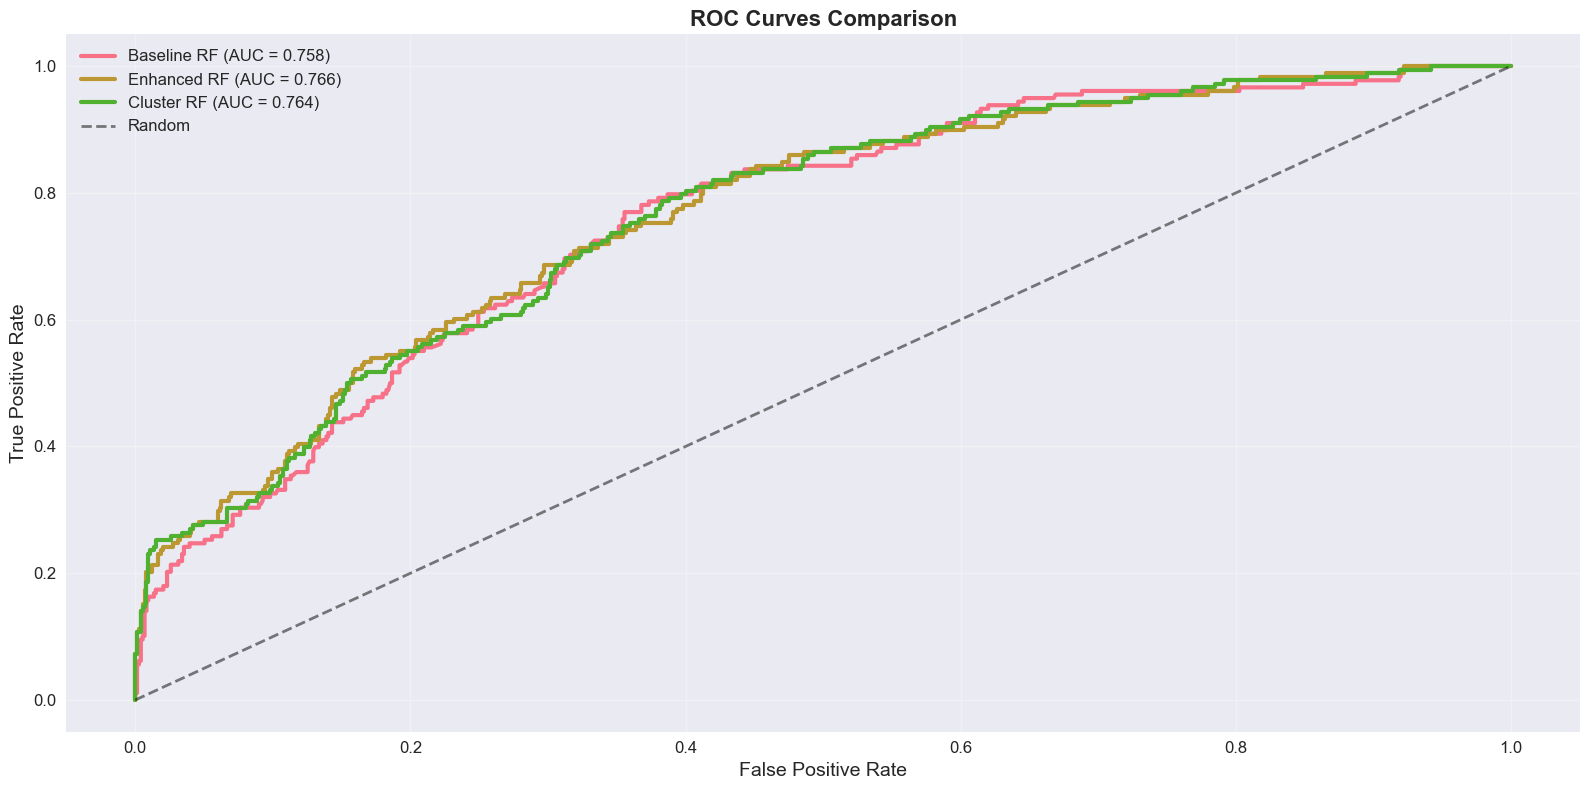

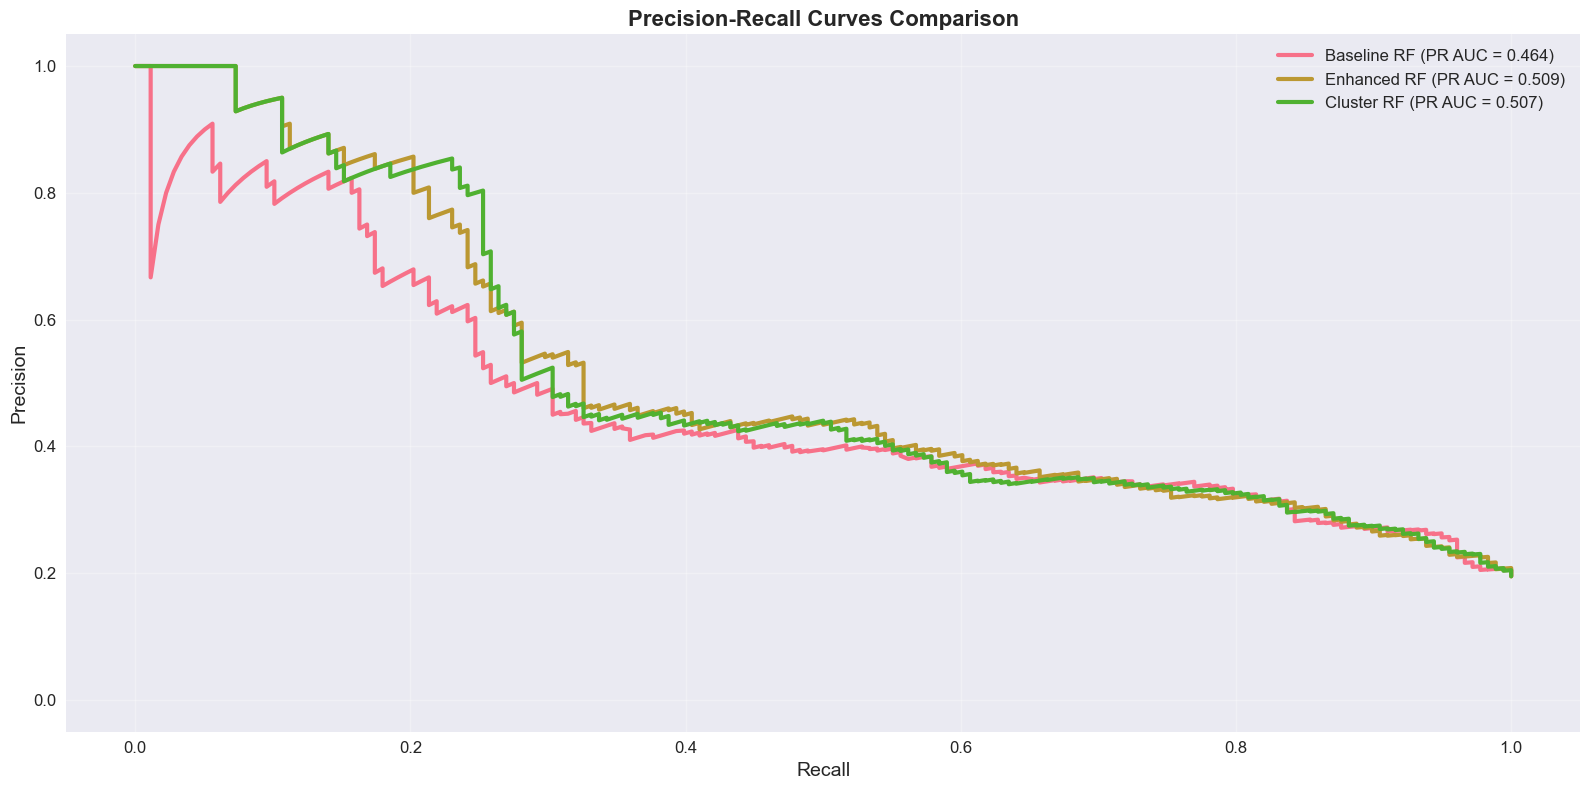

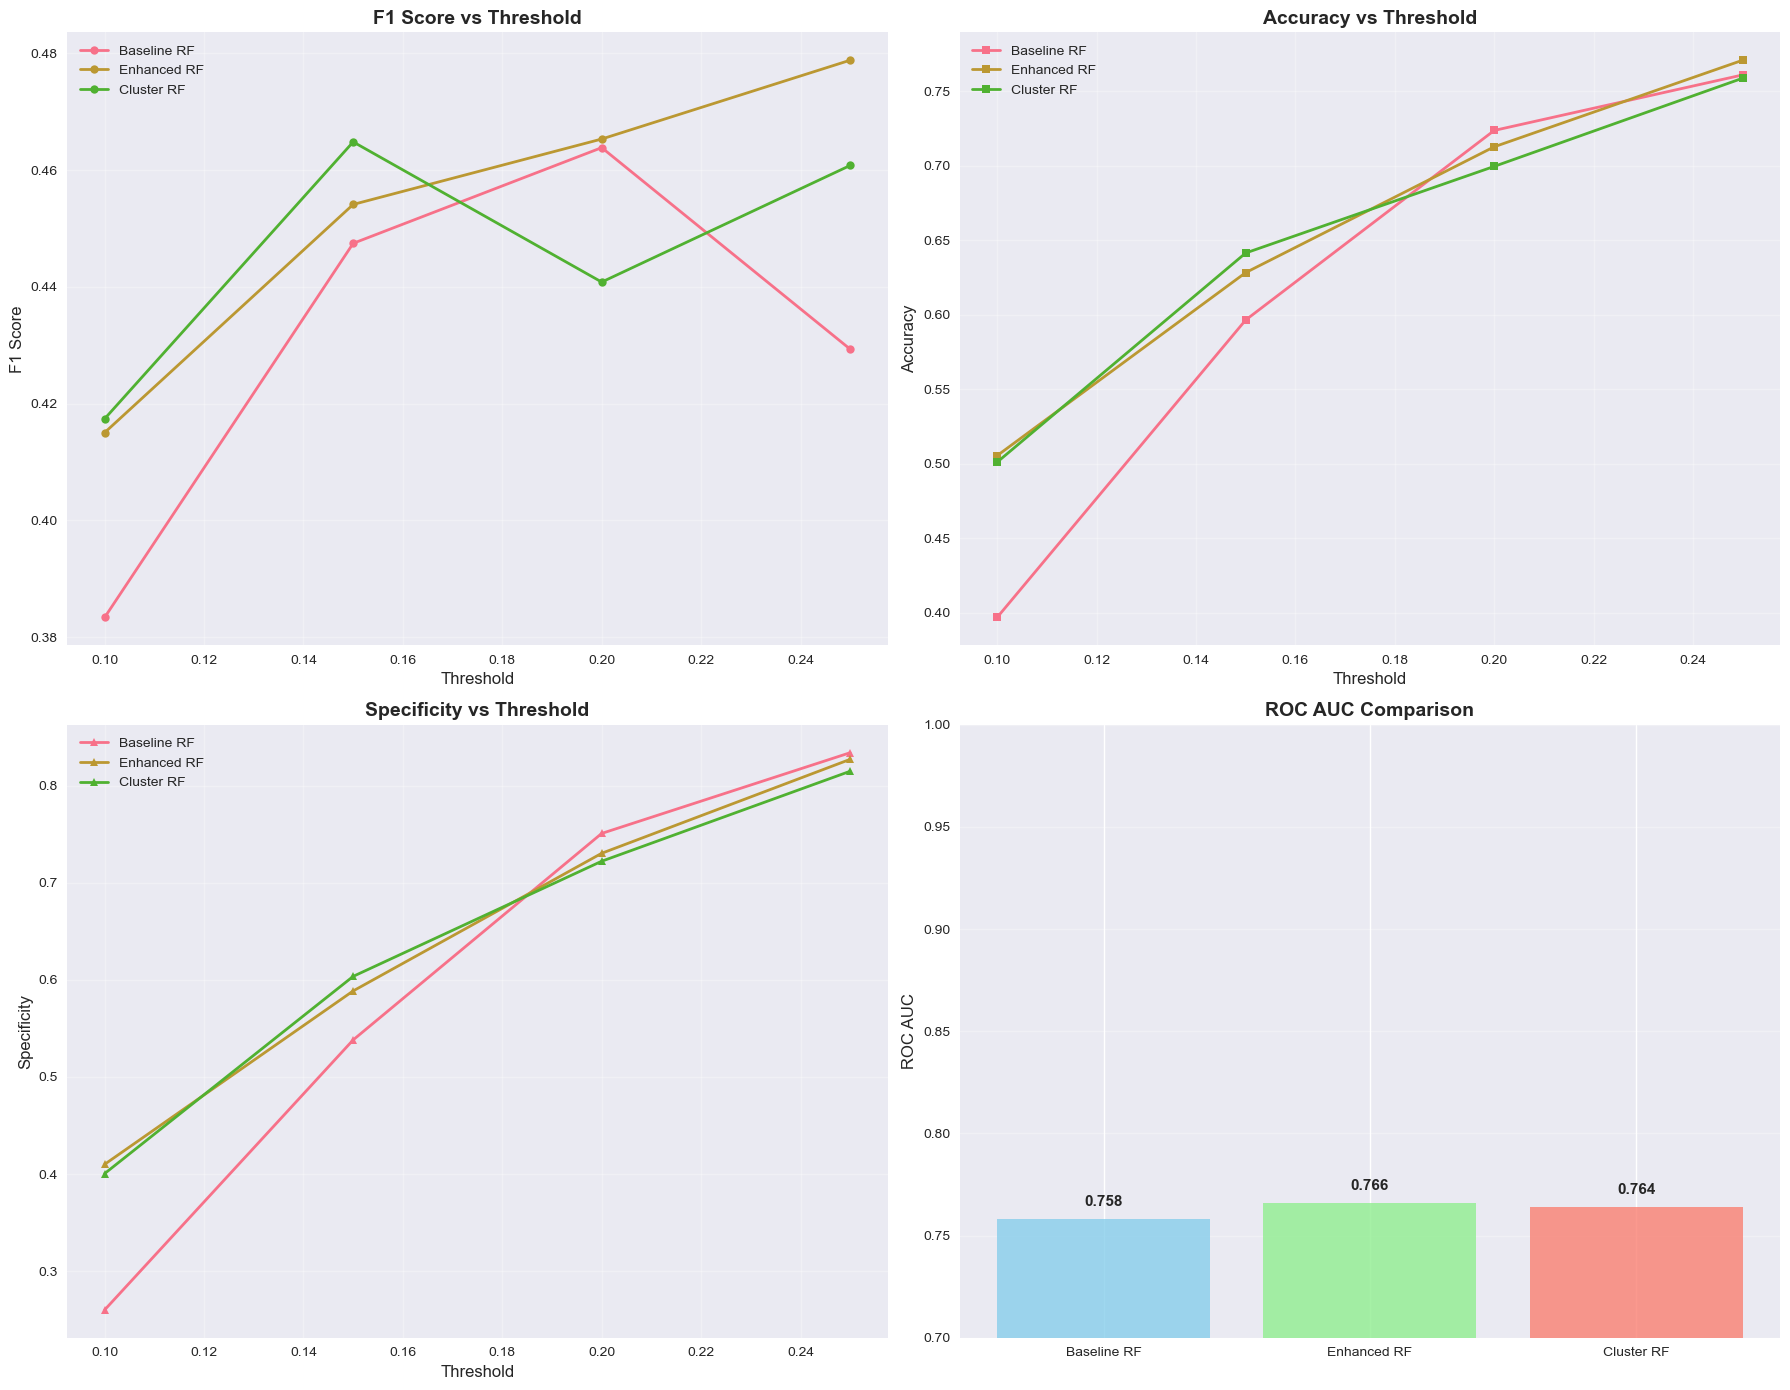

In [75]:
# Define the range of thresholds to evaluate
THRESHOLDS_TO_EVALUATE = [0.1, 0.15, 0.2, 0.25] 

# Define models
models_data = {
    'Baseline RF': (rf_grid_base.best_estimator_, X_test_base),
    'Enhanced RF': (rf_grid_enh.best_estimator_, X_test_enh),
    'Cluster RF': (rf_grid_clust.best_estimator_, X_test_clust)
}

# Store results for all thresholds
all_results = []
model_probas = {} # To store probabilities for ROC and PR curves

for THRESHOLD in THRESHOLDS_TO_EVALUATE:
    results_at_threshold = []
    print(f"\nMODEL PERFORMANCE COMPARISON (Threshold = {THRESHOLD})")
    print("="*60)

    for model_name, (model, X_test_data) in models_data.items():
        # Get predictions
        y_pred_proba = model.predict_proba(X_test_data)[:, 1]
        y_pred_custom = (y_pred_proba >= THRESHOLD).astype(int)

        # Store probabilities once for curves
        if model_name not in model_probas:
            model_probas[model_name] = y_pred_proba

        # Calculate metrics
        cm = confusion_matrix(y_test, y_pred_custom)
        tn, fp, fn, tp = cm.ravel()

        results_at_threshold.append({
            'Model': model_name,
            'Threshold': THRESHOLD,
            'Accuracy': accuracy_score(y_test, y_pred_custom),
            'Precision': precision_score(y_test, y_pred_custom), 
            'Recall': recall_score(y_test, y_pred_custom),
            'F1_Score': f1_score(y_test, y_pred_custom),
            'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
            'Specificity': tn / (tn + fp),
            'proba': y_pred_proba
        })
    
    current_threshold_df = pd.DataFrame(results_at_threshold)
    all_results.append(current_threshold_df)
    
    # Display results for the current threshold
    display_df = current_threshold_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC', 'Specificity']]
    print(display_df.round(4).to_string(index=False))

# Concatenate all results into a single DataFrame for overall analysis
overall_results_df = pd.concat(all_results, ignore_index=True)

# --- Create Visualizations with Larger Size ---

# 1. Threshold Analysis Plot
plt.figure(figsize=(16, 8))
for model_name in models_data.keys():
    model_threshold_data = overall_results_df[overall_results_df['Model'] == model_name]
    plt.plot(model_threshold_data['Threshold'], model_threshold_data['Recall'], 
             label=f'{model_name} Recall', marker='o', markersize=6, linewidth=2)
    plt.plot(model_threshold_data['Threshold'], model_threshold_data['Precision'], 
             label=f'{model_name} Precision', linestyle='--', marker='x', markersize=6, linewidth=2)

plt.xlabel('Threshold', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.title('Recall and Precision vs. Threshold', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 2. ROC Curves
plt.figure(figsize=(16, 8))
for model_name, probas in model_probas.items():
    fpr, tpr, _ = roc_curve(y_test, probas)
    roc_auc = roc_auc_score(y_test, probas)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {roc_auc:.3f})", linewidth=3, markersize=8)

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random', linewidth=2)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 3. Precision-Recall Curves
plt.figure(figsize=(16, 8))
for model_name, probas in model_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, probas)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f"{model_name} (PR AUC = {pr_auc:.3f})", linewidth=3, markersize=8)

plt.xlabel('Recall', fontsize=14)
plt.ylabel('Precision', fontsize=14)
plt.title('Precision-Recall Curves Comparison', fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.ylim([-0.05, 1.05])
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 4. Combined Performance Summary Plot
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# F1 Score vs Threshold
ax1 = axes[0, 0]
for model_name in models_data.keys():
    model_data = overall_results_df[overall_results_df['Model'] == model_name]
    ax1.plot(model_data['Threshold'], model_data['F1_Score'], 
             label=model_name, marker='o', markersize=6, linewidth=2)
ax1.set_xlabel('Threshold', fontsize=12)
ax1.set_ylabel('F1 Score', fontsize=12)
ax1.set_title('F1 Score vs Threshold', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Accuracy vs Threshold
ax2 = axes[0, 1]
for model_name in models_data.keys():
    model_data = overall_results_df[overall_results_df['Model'] == model_name]
    ax2.plot(model_data['Threshold'], model_data['Accuracy'], 
             label=model_name, marker='s', markersize=6, linewidth=2)
ax2.set_xlabel('Threshold', fontsize=12)
ax2.set_ylabel('Accuracy', fontsize=12)
ax2.set_title('Accuracy vs Threshold', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

# Specificity vs Threshold
ax3 = axes[1, 0]
for model_name in models_data.keys():
    model_data = overall_results_df[overall_results_df['Model'] == model_name]
    ax3.plot(model_data['Threshold'], model_data['Specificity'], 
             label=model_name, marker='^', markersize=6, linewidth=2)
ax3.set_xlabel('Threshold', fontsize=12)
ax3.set_ylabel('Specificity', fontsize=12)
ax3.set_title('Specificity vs Threshold', fontsize=14, fontweight='bold')
ax3.legend(fontsize=10)
ax3.grid(True, alpha=0.3)

# ROC AUC Comparison (Bar plot)
ax4 = axes[1, 1]
model_names = list(model_probas.keys())
auc_scores = [roc_auc_score(y_test, model_probas[name]) for name in model_names]
bars = ax4.bar(model_names, auc_scores, color=['skyblue', 'lightgreen', 'salmon'], alpha=0.8)
ax4.set_ylabel('ROC AUC', fontsize=12)
ax4.set_title('ROC AUC Comparison', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='y')
ax4.set_ylim([0.7, 1.0])

# Add value labels on bars
for bar, score in zip(bars, auc_scores):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.005,
             f'{score:.3f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

### **Performance Analysis Conclusions:**

**ROC AUC Comparison:**
- **Baseline RF**: 0.758
- **Enhanced RF**: 0.766 (+0.008 improvement)  
- **Cluster RF**: 0.764 (-0.002 vs Enhanced)

**1. Enhanced Model is Superior:**
The Enhanced RF model achieves the **highest ROC AUC (0.766)**, demonstrating that engineered variability features provide significant predictive value beyond clustering.

**2. Clustering Impact is Negligible:**
Adding cluster information provides **no meaningful improvement** over the enhanced model. The slight AUC decrease (-0.002) suggests that **clustering does not add predictive value** beyond the engineered features.

**3. Optimal Threshold Selection:**
**Threshold 0.15 appears most suitable for clinical use**. At threshold 0.2, there is a **significant recall drop** (from ~80% to ~60-64%), which could result in missing critical high-risk patients.

**4. Clinical Recommendation:**
For mortality prediction, the **Enhanced RF model at threshold 0.15** is optimal, maintaining **~80% recall** while achieving the highest overall AUC performance without clustering complexity.

### **Feature Importance - Enhanced Model**

FEATURE IMPORTANCE TABLE - ENHANCED MODEL:
             Feature  Importance
0               sofa      0.2068
1            spo2_cv      0.1925
2                age      0.1694
3          meanbp_cv      0.1505
4     platelet_range      0.1073
5   creatinine_range      0.0771
6  metastatic_cancer      0.0355
7         is_medical      0.0220
8               vent      0.0201
9            is_male      0.0189


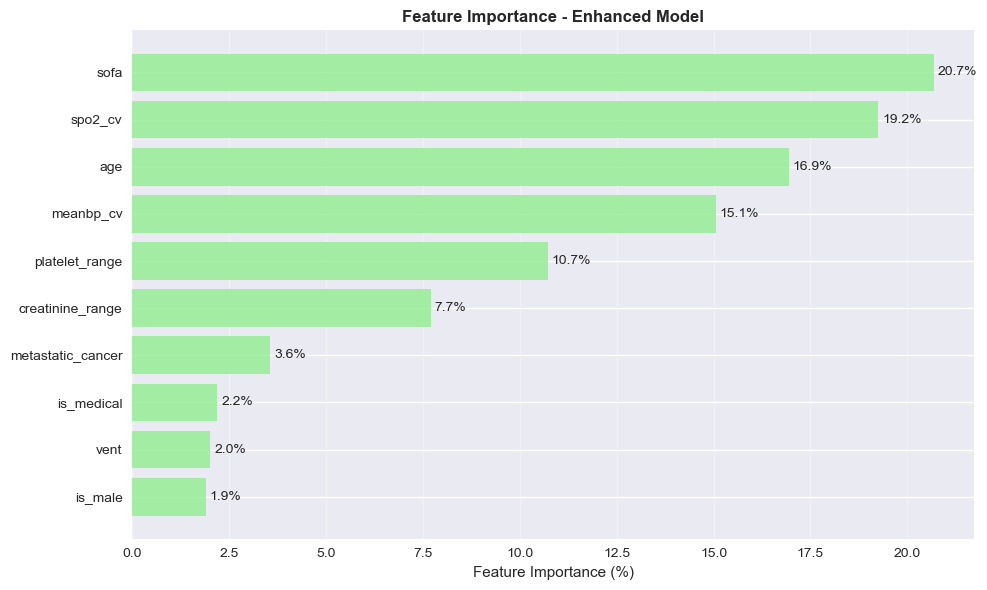

In [76]:
# Get feature importance from the enhanced model
feature_importance = rf_grid_enh.best_estimator_.feature_importances_

# Define feature names matching the enhanced model structure
continuous_enh = ['age', 'sofa', 'creatinine_range', 'platelet_range', 'spo2_cv', 'meanbp_cv']
binary_enh = ['is_male', 'metastatic_cancer', 'vent', 'is_medical']

# Complete feature names list 
feature_names_enhanced = continuous_enh + binary_enh

# Create feature importance DataFrame
importance_df = pd.DataFrame({
    'Feature': feature_names_enhanced,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False).reset_index(drop=True)

print("FEATURE IMPORTANCE TABLE - ENHANCED MODEL:")
print("=" * 50)
print(importance_df.round(4))

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

importance_pct = importance_df['Importance'] * 100

bars = ax.barh(range(len(importance_df)), importance_pct, 
               color='lightgreen', alpha=0.8)
ax.set_yticks(range(len(importance_df)))
ax.set_yticklabels(importance_df['Feature'])
ax.set_xlabel('Feature Importance (%)')
ax.set_title('Feature Importance - Enhanced Model', fontweight='bold')
ax.grid(True, alpha=0.3, axis='x')

# Add percentage labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax.text(width + 0.1, bar.get_y() + bar.get_height()/2, 
            f'{width:.1f}%', ha='left', va='center')

ax.invert_yaxis()
plt.tight_layout()
plt.show()